In [1]:
library(data.table)
library(stringr)
library(pheatmap)
library(ape)
library(ggplot2)
library(Rtsne)
library(sva)
library(VennDiagram)
library(readxl)
library(energy)
library(MASS)
library(quantreg)
library(limma)
library(Glimma)
library(edgeR)
library(RColorBrewer)
library(minerva)
library(dbscan)
library(amap)
library(NbClust)
library(apeglm)
library(gplots)
library(colorspace)
library(dendextend)
library(data.table)
library(topGO)
library(treemap)
library(ggbiplot)
library(factoextra)
library(ggrepel)
library(gridExtra)
library(cowplot)
library(parallel)
library(randomForest)
library(e1071)
library(adabag)
library(ggpubr)
library(dbscan)
library(dict)
library(patchwork)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.
Loading required package: genefilter
Loading required package: BiocParallel
Loading required package: grid
Loading required package: futile.logger

Attaching package: ‘futile.logger’

The following object is masked from ‘package:mgcv’:

    scat


Attaching package: ‘VennDiagram’

The following object is masked from ‘package:ape’:

    rotate


Attaching package: ‘MASS’

The following object is masked from ‘package:genefilter’:

    area

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


---------------------
Welcome to dendextend version 1.13.4
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github pag

In [2]:
color_AD <- "#FF3300"
color_ND <- "blue"
color_CHC <- "#FFCC00"
font_size <- 10
font_size_add <- 2

circle_size_1 <- 2
circle_size_2 <- 3

In [3]:
setwd("~/ownCloud/Meng/")

In [4]:
cell_type_matrix <- read.table("R_workstation/100_plus_proteomic_cell_type_enrichment/EWCE_celltype_v2.tsv",
                               header =TRUE,
                               stringsAsFactors=F, sep = "\t")

In [5]:
cell_type_matrix[grep(";", cell_type_matrix$protein), ]$celltype <- NA

In [6]:
protein_info <- read.table("100_plus_results/Protein basic info.tsv", 
                           sep = "\t", header =TRUE, stringsAsFactors=F)

In [7]:
High_quality_protein_intensity_matrix <- read.table('R_workstation/100_plus_proteomic_DATA/High_quality_protein_intensity_matrix.tsv', header =TRUE,
                                                    stringsAsFactors=F, sep = "\t")
dim(High_quality_protein_intensity_matrix)

[1] 3448  191

In [8]:
load("100_plus_project/Metadata/metadata_clean_update20211215.Rdata")
#metadata_clean
metadata <- metadata_clean

names_sample <- as.array(colnames(High_quality_protein_intensity_matrix)[2:ncol(High_quality_protein_intensity_matrix)])
names_sample <- as.vector(apply(names_sample, 1, function(names){return (str_sub(names, 11))}))

filenames_map_index <- integer(length(names_sample))
for (i in 1:length(names_sample)){
    if ((names_sample[i] %in% metadata[,"Mass-Spec filenames (1)"]) | 
        (names_sample[i] %in% metadata[,"Mass-Spec filenames (2)"]))
        filenames_map_index[i] <- ifelse(length(which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))==0,
                                     which(metadata[,"Mass-Spec filenames (2)"] == names_sample[i]), 
                                     which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))
    else
        print("ERROR, file name not in metadata!")
}

metadata <- metadata[filenames_map_index, ][c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", 
                                              "Abeta", "APOE")]
colnames(metadata) <- c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", "amyloid", "apoe")
metadata$filenames <- names_sample

metadata$sex[(metadata$sex=='F') | (metadata$sex=='f')] <- "F"
metadata$sex[(metadata$sex=='M') | (metadata$sex=='m')] <- "M"
metadata$braak <- as.numeric(metadata$braak)
metadata$age <- as.numeric(metadata$age)


index_AD <- which(metadata$GROUP == "AD")
index_CHC <- which(metadata$GROUP == "CHC")
index_ND <- which(metadata$GROUP == "ND")
num_AD <- length(index_AD)
num_CHC <- length(index_CHC)
num_ND <- length(index_ND)

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$braak))),]$braak <- median(metadata[index_ND,]$braak, na.rm = TRUE)

metadata$fBraak <- metadata$braak
metadata[which(metadata$braak == 0), ]$fBraak <- 1

metadata$cBraak <- as.numeric(lapply(metadata$braak, function(braak){if (braak==0 | braak==1 | braak==2)
                                                                return(1)
                                                          if (braak==3 | braak==4)
                                                                return(2)
                                                          if (braak==5 | braak==6)
                                                                return(3)}))



metadata[which((metadata$GROUP=="AD") & (is.na(metadata$amyloid))),]$amyloid <- 3
metadata[which((metadata$GROUP=="ND") & (is.na(metadata$amyloid))),]$amyloid <- 1

get_mod <- function(apoe){
    apoe_count <- as.matrix(table(apoe))
    return (rownames(apoe_count)[which.max(apoe_count)])
}

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$apoe))),]$apoe <- get_mod(metadata[index_ND,]$apoe)

metadata$apoe_OR <- as.numeric(metadata$apoe)

metadata[which((metadata$apoe == 22)|(metadata$apoe == 23)|(metadata$apoe == 32)),]$apoe_OR <- 0.6
metadata[which((metadata$apoe == 24)|(metadata$apoe == 42)),]$apoe_OR <- 2.6
metadata[which(metadata$apoe == 33),]$apoe_OR <- 1
metadata[which((metadata$apoe == 34)|(metadata$apoe == 43)),]$apoe_OR <- 3.2
metadata[which(metadata$apoe == 44),]$apoe_OR <- 14.9

convert_time_2_numeric <- function(pmd){
    if (is.na(pmd))
        return (NA)
    else
        return (as.numeric(str_sub(pmd, start=1, end=2))+as.numeric(str_sub(pmd, 4))/60)
}

metadata$pmd_numeric <- apply(metadata["pmd"], 1, convert_time_2_numeric)
metadata[which(is.na(metadata$pmd_numeric)),]$pmd_numeric <- median(metadata$pmd_numeric, na.rm = TRUE)


MMSE_data <- read_excel("100_plus_project/Metadata/2020_04_02_CentenarianData_manualaddMMSE.xlsx",sheet=1,col_names=TRUE, na="NA")
#MMSE_data
MMSE_data <- MMSE_data[c('NBB', 'MMSE_LV')]
#nrow(MMSE_data)

metadata$MMSE <- rep(NA, nrow(metadata))

for (i in 1:nrow(metadata)){
    if (metadata[i,]$GROUP == "CHC"){
        metadata[i,]$MMSE <- MMSE_data[which(MMSE_data$NBB == metadata[i,]$nbb),]$MMSE_LV
    }
}

metadata$MMSE <- as.numeric(metadata$MMSE)
#metadata$amyloid <- factor(metadata$amyloid, levels = c("O", "A", "B", "C"))
#
#metadata$Abeta <- 0
#metadata[metadata$amyloid == "A", ]$Abeta <- 1
#metadata[metadata$amyloid == "B", ]$Abeta <- 2
#metadata[metadata$amyloid == "C", ]$Abeta <- 3

metadata$age_level <- NA
metadata[metadata$age<=70,]$age_level <- 1
metadata[(metadata$age>70)&(metadata$age<=80),]$age_level <- 1
metadata[(metadata$age>80)&(metadata$age<=90),]$age_level <- 2
metadata[(metadata$age>90)&(metadata$age<100),]$age_level <-2
metadata[(metadata$age>=100),]$age_level <- 3

metadata$MMSE_level <- NA
metadata[which(metadata$MMSE >= 26),]$MMSE_level <- 2
metadata[which((metadata$MMSE >= 23) & (metadata$MMSE < 26)),]$MMSE_level <- 1
metadata[which(metadata$MMSE < 23),]$MMSE_level <- 1

colnames(metadata)

[1] "nbb"         "autopsy"     "sex"         "age"         "weight"     
 [6] "GROUP"       "pmd"         "braak"       "amyloid"     "apoe"       
[11] "filenames"   "fBraak"      "cBraak"      "apoe_OR"     "pmd_numeric"
[16] "MMSE"        "age_level"   "MMSE_level"

In [9]:
metadata

nbb        autopsy    sex age weight GROUP pmd   braak amyloid apoe
121 2016-020   S16/020    F   102 955    CHC   06:10 2     1       23  
125 2016-044   S16/044    F   102 1015   CHC   05:17 3     3       33  
127 2016-094   S16/094    F   104 1045   CHC   07:55 3     1       33  
16  2004-011   04/037     F    84 1017   AD    05:55 5     3       33  
182 2010-101   S10/292    M    64 1233   AD    04:35 6     3       32  
193 2002-024   S02/055    F    75 1153   ND    05:30 1     3       42  
31  2001-081   01/184     F    93 1010   AD    05:05 5     3       33  
57  1997-091   S97/235    F    85 1000   AD    02:00 5     3       43  
77  2011-072   S11/072    F    76 1072   ND    07:15 2     0       33  
79  2007-082   S07/308    M    81 1194   ND    07:55 2     0       33  
95  2005-060   S05/217    M    91 1188   ND    08:00 1     2       33  
123 2016-032   S16/032    M   101 1060   CHC   05:30 3     1       34  
136 2017-014   S17/014    F   108 940    CHC   06:10 2     1       33  
151 2017-129   S17/129    F   107 1130   CHC   05:40 3     1       33  
177 2004-030   S04/088    F    89 962    AD    04:40 5     3       43  
194 2003-013   S03/035    F    82 1175   ND    11:30 1     0       33  
200 2008-106   S08/325    F    87 1010   ND    05:00 2     0       33  
202 2009-022   S09/067    F    77 1111   ND    02:55 1     2       33  
219 SVU 10-277 SVU 10/277 M    50 NA     ND    NA    1     1       33  
4   2005-029   S05/106    M    67 1252   AD    04:10 5     3       33  
74  2001-019   01/059     F    92 1066   AD    04:55 5     3       43  
100 2014-051   S14/051    M    92 1210   ND    07:45 3     2       33  
108 859        NABCA15-08 M    72 1355   ND    11:45 0     1       33  
120 2016-008   S16/008    M   102 1075   CHC   07:45 4     3       33  
126 2016-058   S16/058    F   103 1010   CHC   05:55 1     0       23  
12  2000-099   S00/206    F    78 920    AD    03:35 6     3       33  
130 2016-109   S16/109    M   102 1205   CHC   04:05 3     2       33  
143 2017-053   S17/053    F   102 1090   CHC   10:45 3     1       33  
171 2002-072   S02/214    F    62 912    AD    04:45 6     3       43  
175 2003-057   S03/150    F    68 985    AD    03:50 6     3       32  
⋮   ⋮          ⋮          ⋮   ⋮   ⋮      ⋮     ⋮     ⋮     ⋮       ⋮   
207 2011-044   S11/044    M    51 1450   ND    07:45 0     0       43  
24  1999-064   S99/134    M    89 1135   AD    04:05 5     3       33  
34  2002-104   02/314     F    94 1290   AD    05:00 4     3       33  
47  2003-016   S03/038    F    72 1145   AD    04:55 6     3       43  
52  2007-059   S07/225    F    81 888    AD    05:15 6     3       43  
53  2007-009   07/036     F    82 1135   AD    05:55 4     3       43  
54  2002-047   S02/121    F    83 919    AD    07:17 5     3       43  
58  2002-056   02/160     F    85 1183   AD    03:45 5     3       43  
61  2004-043   S04/134    F    88 1015   AD    05:10 5     3       43  
69  2004-025   04/076     F    90 904    AD    05:30 4     3       43  
71  2005-012   05/044     F    91 940    AD    05:45 6     3       43  
93  2001-006   S01/024    F    91 1043   ND    05:45 1     2       22  
97  2012-090   S12/090    F    91 1052   ND    04:10 3     1       43  
110 889        NABCA16-02 F    79 1285   ND    05:25 2     1       33  
112 2014-037   S14/037    F   101 1115   CHC   07:27 4     3       34  
13  1999-105   S99/223    M    79 1120   AD    03:45 5     3       33  
142 2017-046   S17/046    F   102 1040   CHC   05:50 3     2       33  
148 2017-104   S17/104    F   104 1150   CHC   07:05 3     2       24  
164 2018-065   S18/065    F   104 1208   CHC   04:00 5     3       23  
199 2008-097   S08/298    M    58 1366   ND    05:15 1     0       33  
21  2001-008   01/032     F    88 890    AD    12:15 4     3       33  
27  2000-097   00/204     F    91 958    AD    05:00 5     3       33  
29  1999-112   S99/240    F    92 1031   AD    03:45 5     3       32  
30  2005-011   S05/040    F    93 970    AD 

In [10]:
summary(subset(metadata, GROUP == "ND")$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  50.00   76.00   84.00   81.08   91.00   96.00 

In [11]:
length(subset(metadata, GROUP == "ND")$age)

[1] 53

In [12]:
cal_sample_batch_index <- function(sample_names){
    sample_index <- apply(as.data.frame(sample_names), 1, str_sub, -3)
    for (i in 1:length(sample_index)){
        sample_index[i] <- gsub("_", "0", sample_index[i])
    }
    sample_index <- as.numeric(sample_index)
    sample_index <- (sample_index - 1) %/% 8
    extra_batch <- max(sample_index, na.rm=TRUE) + 1
    sample_index[is.na(sample_index)] <- extra_batch
    return(sample_index)
}

protein_intensity_combat <- ComBat(dat=log2(as.matrix(High_quality_protein_intensity_matrix[,-1])), 
                                     batch=cal_sample_batch_index(metadata$filenames), mod=NULL, par.prior=TRUE, prior.plots=FALSE)
rownames(protein_intensity_combat) <- High_quality_protein_intensity_matrix$protein

Warning message in cal_sample_batch_index(metadata$filenames):
“NAs introduced by coercion”Found29batches
Adjusting for0covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [13]:
cal_ANOVA_test <- function(variable, group){
    pdata <- data.frame(variable=as.numeric(drop(t(variable))), group=factor(group))
    test_anova <- oneway.test(variable~group, data=pdata, var.equal=F)
    return(test_anova$p.value)
}

lm_sig_test <- function(re_variable, exp_variable){
    lm_data <- data.frame(re=as.numeric(re_variable), exp=as.numeric(exp_variable))
    fit_lm <- lm(re~exp, data = lm_data)
    #F <- summary(fit_lm)$fstatistic
    #return(pf(F[1], F[2], F[3], lower.tail = FALSE))
    return(summary(fit_lm)$coefficients[2,][c(1,4)])
}

cal_effect_size_mmd_median <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    
    if(which.max(intens) > which.min(intens)) 
        return(log2(max(intens)/min(intens)))
    else
        return(log2(min(intens)/max(intens)))
}

cal_median_for_stage <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    return(intens)
}

cal_mean_for_stage <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, mean(protein_intens[which(braak == i)]))
    }
    return(intens)
}
cor_test <- function(x, y){
    cor <- cor.test(x, y, method="pearson", exact=F)
    
    return(c(cor$estimate, cor$p.value))
}

In [14]:
cal_PC1_for_stage <- function(protein_intens, braak){
    intens <- NULL
    for(i in sort(unique(braak))){
        intens <- cbind(intens, 
                    prcomp(protein_intens[, which(braak == i)], center = TRUE, scale = TRUE)$x[,1])
    }
    return(intens)
}

In [15]:
cal_median_for_age <- function(protein_intens, age){
    intens <- numeric(0)
    for(i in sort(unique(age))){
        intens <- c(intens, median(protein_intens[which(age == i)]))
    }
    return(intens)
}

In [16]:
get_sig_protein <- function(proteins){
    single_proteins <- vector()
    for(i in proteins){
        single_proteins <- c(single_proteins, unlist(strsplit(i, split = ";")))
    }
    
    return(single_proteins)
}

In [17]:
get_single_protein <- function(proteins){
    single_proteins <- proteins[-grep(";", proteins)]
    return(single_proteins)
}

In [18]:
get_first_protein <- function(proteins){
    single_proteins <- vector()
    for(i in proteins){
        #print(i)
        #print(unlist(strsplit(i, split = ";"))[1])
        single_proteins <- c(single_proteins, unlist(strsplit(i, split = ";"))[1])
    }
    return(single_proteins)
}

In [19]:
get_first_unique_protein <- function(proteins){
    existed <- get_single_protein(proteins)
    
    single_proteins <- vector()
    for(i in proteins){
        sub_proteins <- unlist(strsplit(i, split = ";"))
        if(length(sub_proteins) == 1)
            single_proteins <- c(single_proteins, sub_proteins)
        else{
            present <- TRUE
            for(j in sub_proteins){
                if(!(j %in% existed)){
                    existed <- c(existed, j)
                    single_proteins <- c(single_proteins, j)
                    present <- FALSE
                    break
                }
            }
            if(present){
                single_proteins <- c(single_proteins, i)
            }
        }
    }
    
    real_single_proteins <- get_first_protein(single_proteins)
    
    return(real_single_proteins)
    
    
}

#### Aging related proteins analysis

##### Generate mean abundance in each age

In [20]:
Age_test_index <- which((metadata$GROUP == "ND"))
length(Age_test_index)

[1] 53

In [21]:
calc_distribution_per_age <- function(index, age, num_limit){
    data <- data.frame(age = age, abundance = protein_intensity_combat[index, ][Age_test_index])
    
    data <- data[order(data$age), ]
    breaks <- seq(1, nrow(data), num_limit)
    #print(ND_start)
    #print(ND_end)
    
    intens_perW <- as.numeric(lapply(breaks[-length(breaks)], 
                                     function(x){return(mean(data[x:(x+num_limit-1), ]$abundance))}))
    
    intens_perW <- c(intens_perW, mean(data[breaks[length(breaks)]:length(data), ]$abundance))
    
    return(intens_perW)
}

test <- calc_distribution_per_age(1, 
                                  metadata[Age_test_index, ]$age, 
                                  num_limit = 5)

calc_age <- function(age, num_limit){
    data <- age[order(age)]
    breaks <- seq(1, length(data), num_limit)

    Age <- as.numeric(lapply(breaks[-length(breaks)], 
                             function(x){return(mean(data[x:(x+num_limit-1)]))}))
    Age <- c(Age, mean(data[breaks[length(breaks)]:length(data)]))
    
    return(Age)
}

In [22]:
calc_distribution_per_age <- function(index, age, num_limit, boots = 50){
    set.seed(123)
    data <- data.frame(age = age, hallmark = protein_intensity_combat[index, ][Age_test_index])
    
    data <- data[order(data$age), ]
    start <- data[floor(num_limit/2) + 1, ]$age
    end <- data[(nrow(data) - floor(num_limit/2)), ]$age
    #print(ND_start)
    #print(ND_end)
    
    hallmark_perAge <- NULL
    
    for(i in start:end){
        
        # start age
        if(i == start){
            ND_index <- 1:(num_limit-1)
            my_mean <- mean(data[ND_index,]$hallmark, na.rm = TRUE)
            hallmark_perAge <- c(hallmark_perAge, my_mean)
        }
        
        # end age
        if(i == end){
            ND_index <- (nrow(data) - num_limit + 2):nrow(data)
            my_mean <- mean(data[ND_index,]$hallmark, na.rm = TRUE)
            hallmark_perAge <- c(hallmark_perAge, my_mean)
        }

        
        if((i > start) & (i < end) & (i %in% unique(data$age))){
            if(length(which(data$age == i)) >= (num_limit)){
                ND_index <- which(data$age == i)
                
                my_mean <- mean(data[ND_index,]$hallmark, na.rm = TRUE)
                hallmark_perAge <- c(hallmark_perAge, my_mean)
            }
            else{
                middle_index <- round(median(which(data$age == i)))
                
                start_end_age <- data[c((middle_index - floor(num_limit/2)), 
                                        (middle_index + floor(num_limit/2))), ]$age
                
                #print(middle_index)
                #print(start_end_age)
                
                constent_index <- which((data$age > start_end_age[1]) & (data$age < start_end_age[2]))
                
                start_residual_num <- constent_index[1] - (middle_index - floor(num_limit/2))
                end_residual_num <- (middle_index + floor(num_limit/2)) - constent_index[length(constent_index)]
                
                start_age_index <- which(data$age == start_end_age[1])
                end_age_index <- which(data$age == start_end_age[2])
                
                if((length(start_age_index)<start_residual_num) | (length(end_age_index)<end_residual_num))
                    cat("This is impossible!!!")
                
                hallmark <- NULL
                for(j in 1:boots){
                    residual_i <- c(sample(start_age_index, size = start_residual_num, replace = FALSE), 
                                    sample(end_age_index, size = end_residual_num, replace = FALSE))
                    
                    my_hallmark <- rbind(hallmark, 
                                         data[c(constent_index, residual_i), ]$hallmark)
                }
                #print(length(constent_index))
                #print(my_hallmark)
                
                my_hallmark <- colMeans(my_hallmark)
                
                my_mean <- mean(my_hallmark, na.rm = TRUE)
                
                #my_mean <- mean(data[(middle_index - floor(num_limit/2)):(middle_index + floor(num_limit/2)),]$hallmark, na.rm = TRUE)

                hallmark_perAge <- c(hallmark_perAge, my_mean)
                
            }

        }
    }
    
    return(hallmark_perAge)
}

#test <- calc_distribution_per_age(1, 
#                                  metadata[Age_test_index, ]$age, 
#                                  num_limit = 25)

calc_age <- function(age, num_limit){
    data <- age[order(age)]
    start <- data[floor(num_limit/2) + 1]
    end <- data[(length(data) - floor(num_limit/2))]

    Age <- NULL
    
    for(i in start:end){
        if(i %in% unique(data)){
            Age <- c(Age, i)
        }
    }
    return(Age)
}

In [23]:
w_size <- 11

In [24]:
single_age <- calc_age(metadata[Age_test_index, ]$age, w_size)

In [25]:
#system.time(
    mean_intens_perage <- mclapply(1:nrow(protein_intensity_combat), calc_distribution_per_age, 
                                   mc.cores = detectCores() - 2,
                                   metadata[Age_test_index, ]$age, w_size)
#)

In [26]:
mean_intens_perage <- t(as.data.frame(mean_intens_perage))

In [27]:
rownames(mean_intens_perage) <- rownames(protein_intensity_combat)

In [28]:
dim(mean_intens_perage)

[1] 3448   20

In [29]:
length(single_age)

[1] 20

In [30]:
Age_related_proteins_lm <- as.data.frame(t(apply(mean_intens_perage, 1,
                                                 lm_sig_test, single_age)))
colnames(Age_related_proteins_lm) <- c("effect_size", "p_value")
Age_related_proteins_lm$adjusted_p_value <- p.adjust(Age_related_proteins_lm$p_value, method="bonferroni")

lm_index <- which(Age_related_proteins_lm$adjusted_p_value<0.05)
length(lm_index)

[1] 174

In [82]:
Age_related_proteins_lm[which((Age_related_proteins_lm$adjusted_p_value < 0.001) & (abs(Age_related_proteins_lm$effect_size) > 0)), ]

effect_size  p_value      adjusted_p_value
SLC12A2                            -0.016475472 6.647424e-08 2.292032e-04    
ATP1A2                             -0.005950950 3.547085e-08 1.223035e-04    
AMPH                                0.004290263 6.001488e-08 2.069313e-04    
ATP1A1;ATP1A3                      -0.005284961 4.286399e-09 1.477950e-05    
HADHA                              -0.006187667 1.114208e-07 3.841790e-04    
CIT                                 0.009007322 2.743338e-07 9.459030e-04    
NEFM                               -0.022351275 1.567739e-07 5.405563e-04    
PTGES2                              0.007102573 5.540043e-08 1.910207e-04    
CNP                                -0.031864413 7.223938e-09 2.490814e-05    
TRHDE                              -0.017554158 1.432756e-09 4.940144e-06    
CACNA1E                             0.014524662 9.939724e-08 3.427217e-04    
ALCAM                              -0.010467665 7.871326e-09 2.714033e-05    
NPTX1                               0.009598791 2.024554e-07 6.980663e-04    
TUBB                               -0.004409366 1.130163e-07 3.896801e-04    
MOG                                -0.034791345 2.619608e-08 9.032409e-05    
NEFL                               -0.021551083 6.174507e-08 2.128970e-04    
ANK3                               -0.010477599 4.659970e-08 1.606758e-04    
ICAM5                               0.011693054 4.409998e-08 1.520567e-04    
CNTN1                              -0.005217274 4.183360e-08 1.442423e-04    
TUBB4A;TUBB4B;TUBB8                -0.004454533 2.495941e-11 8.606004e-08    
ATP2B4                              0.007915852 1.176760e-07 4.057470e-04    
AMPD2                               0.007058542 1.294753e-07 4.464308e-04    
SIRT2                              -0.027696317 3.064381e-08 1.056598e-04    
SLC44A1                            -0.025949171 1.239336e-07 4.273231e-04    
TMEM30A                             0.014702642 3.944882e-08 1.360195e-04    
CD9                                -0.031132243 8.770440e-08 3.024048e-04    
C2;CFB                             -0.013279683 3.030935e-09 1.045066e-05    
PTK2B                               0.008040285 3.622518e-09 1.249044e-05    
RAP1GDS1                           -0.005331583 2.789862e-08 9.619443e-05    
MAG                                -0.034574653 8.823622e-08 3.042385e-04    
PDE1A;PDE1C                         0.009891174 2.221398e-07 7.659381e-04    
ABLIM1                              0.014137553 8.864796e-12 3.056582e-08    
CSNK2A1;CSNK2A3                    -0.004144560 4.452080e-11 1.535077e-07    
AP3B1                              -0.006724967 7.018983e-08 2.420145e-04    
IGSF21                             -0.008380533 1.032191e-09 3.558996e-06    
TUBB4A                             -0.007659758 1.400947e-08 4.830465e-05    
ATP1B2                             -0.006685513 4.259292e-08 1.468604e-04    
PUS1                                0.014210716 2.384229e-07 8.220823e-04    
ADAM23                             -0.007803561 1.475177e-07 5.086411e-04    
RIMBP2                              0.009654341 3.774391e-09 1.301410e-05    
UBAP2L                             -0.010621600 2.674364e-08 9.221206e-05    
CCT6B                              -0.003324397 2.554607e-07 8.808284e-04    
RUFY3                              -0.004796571 7.980544e-10 2.751692e-06    
PLP1                               -0.031802062 4.523222e-08 1.559607e-04    
GLTP                               -0.028280878 7.908210e-08 2.726751e-04    
WASH2P;WASH3P;WASH4P;WASH6P;WASHC1 -0.010221230 7.960301e-08 2.744712e-04    
INA;NEFH;NEFL;NEFM                 -0.018082315 8.569056e-08 2.954610e-04    
NCKAP1;NCKAP1L                      0.014418741 1.051173e-07 3.624444e-04    
ARHGAP23                           -0.006931427 2.328034e-09 8.027060e-06    
PIGK                               -0.008314753 8.475764e-08 2.922443e-04    
RPL11                              -0.006397035 1.087111e

In [83]:
sig_index_cut <- which((Age_related_proteins_lm$adjusted_p_value < 0.001) & (abs(Age_related_proteins_lm$effect_size) > 0))

In [70]:
Age_related_proteins_lm_sig <- Age_related_proteins_lm[lm_index[order(Age_related_proteins_lm[lm_index, ]$p_value)], ]

In [71]:
Age_related_proteins_lm_sig[which(Age_related_proteins_lm_sig$effect_size < 0), ]

effect_size  p_value      adjusted_p_value
TUBB4A;TUBB4B;TUBB8                -0.004454533 2.495941e-11 8.606004e-08    
CSNK2A1;CSNK2A3                    -0.004144560 4.452080e-11 1.535077e-07    
RUFY3                              -0.004796571 7.980544e-10 2.751692e-06    
IGSF21                             -0.008380533 1.032191e-09 3.558996e-06    
TRHDE                              -0.017554158 1.432756e-09 4.940144e-06    
ARHGAP23                           -0.006931427 2.328034e-09 8.027060e-06    
C2;CFB                             -0.013279683 3.030935e-09 1.045066e-05    
ATP1A1;ATP1A3                      -0.005284961 4.286399e-09 1.477950e-05    
CNP                                -0.031864413 7.223938e-09 2.490814e-05    
ALCAM                              -0.010467665 7.871326e-09 2.714033e-05    
TUBB4A                             -0.007659758 1.400947e-08 4.830465e-05    
MOG                                -0.034791345 2.619608e-08 9.032409e-05    
UBAP2L                             -0.010621600 2.674364e-08 9.221206e-05    
RAP1GDS1                           -0.005331583 2.789862e-08 9.619443e-05    
SIRT2                              -0.027696317 3.064381e-08 1.056598e-04    
ATP1A2                             -0.005950950 3.547085e-08 1.223035e-04    
CNTN1                              -0.005217274 4.183360e-08 1.442423e-04    
ATP1B2                             -0.006685513 4.259292e-08 1.468604e-04    
PLP1                               -0.031802062 4.523222e-08 1.559607e-04    
ANK3                               -0.010477599 4.659970e-08 1.606758e-04    
NEFL                               -0.021551083 6.174507e-08 2.128970e-04    
SLC12A2                            -0.016475472 6.647424e-08 2.292032e-04    
AP3B1                              -0.006724967 7.018983e-08 2.420145e-04    
GLTP                               -0.028280878 7.908210e-08 2.726751e-04    
WASH2P;WASH3P;WASH4P;WASH6P;WASHC1 -0.010221230 7.960301e-08 2.744712e-04    
PIGK                               -0.008314753 8.475764e-08 2.922443e-04    
INA;NEFH;NEFL;NEFM                 -0.018082315 8.569056e-08 2.954610e-04    
CD9                                -0.031132243 8.770440e-08 3.024048e-04    
MAG                                -0.034574653 8.823622e-08 3.042385e-04    
RPL11                              -0.006397035 1.087111e-07 3.748357e-04    
⋮                                  ⋮            ⋮            ⋮               
VPS25                              -0.008104773 4.933951e-06 0.01701226      
RPL22                              -0.004201671 5.024808e-06 0.01732554      
RALA                               -0.005005557 5.058766e-06 0.01744262      
SLC24A2                            -0.010631876 6.011359e-06 0.02072717      
PNMA8B                             -0.032080538 6.629864e-06 0.02285977      
GNA13                              -0.009971982 6.638110e-06 0.02288820      
STX5                               -0.010437433 6.722818e-06 0.02318028      
PIP4K2A                            -0.013758891 6.881743e-06 0.02372825      
PTPRD;PTPRS                        -0.005448181 7.028319e-06 0.02423364      
ARHGAP44                           -0.005180084 7.032765e-06 0.02424897      
CLDN11                             -0.027221329 7.057018e-06 0.02433260      
DIP2A;DIP2C                        -0.008632643 7.486558e-06 0.02581365      
RPS13                              -0.005580521 7.504611e-06 0.02587590      
NAP1L1                             -0.005102386 7.609953e-06 0.02623912      
CHMP4B                             -0.005484265 7.848611e-06 0.02706201      
INA;NEFH;NEFL;NEFM;VIM             -0.015797299 7.906804e-06 0.02726266      
GLMN                               -0.005719628 8.834196e-06 0.03046031      
AK3                                -0.017769943 9.276217e-06 0.03198440      
PNCK                               -0.030848688 9.823276e-06 0.03387066      
WRN                                -0.014655998 9.965687e

In [97]:
formatC(Age_related_proteins_lm_sig[1, ]$adjusted_p_value, format = "e", digits = 2)

[1] "3.06e-08"

In [107]:
protein_list <- c("ABLIM1", "PTK2B", "RIMBP2", "TMEM30A", 
                  "ICAM5", "PTGES2", "AMPH", "CACNA1E",
                  "TUBB4A;TUBB4B;TUBB8", "CSNK2A1;CSNK2A3", "RUFY3", "IGSF21", 
                  "TRHDE", "ARHGAP23", "C2;CFB", "ATP1A1;ATP1A3")

In [108]:
plot_protective_proteins_aging <- function(index){
    temp_prot <- data.frame(age = as.numeric(metadata$age),
                            group = as.character(metadata$GROUP),
                            intensity = as.numeric(protein_intensity_combat[index,]))
    
    #print(length(which((temp_prot$age >= 80)&(temp_prot$intensity < 6.5)&(temp_prot$group == "ND"))))
    temp_prot <- subset(temp_prot, group != "AD")
    temp_prot$group <- factor(temp_prot$group, levels=c("ND", "AD", "CHC"))
    
    p <- ggplot(subset(temp_prot, group == "ND"), aes(x = age, y = intensity, col = group))+
        geom_point() +
        geom_smooth(method = "lm", formula = y ~ x, fullrange=TRUE, level = 0.9) +
        xlab("Age [y]") +
        ylab("Abundance (log2)") +
        ggtitle(rownames(protein_intensity_combat)[index]) +
        #geom_label(aes(x=60, y=max(temp_prot$intensity), 
        #               label=paste("β=", round(Age_related_proteins_lm[index, ]$effect_size, 3), "\n",
        #        "FDR=", formatC(Age_related_proteins_lm[index, ]$adjusted_p_value, format = "e", digits = 2), sep="")),
        #           color="black", 
        #           size=3, angle=0,
        #           label.size = NA) +
    
        scale_color_manual(name="Group", breaks = c("ND", "AD", "CHC"), 
                           values = c(color_ND, color_AD, color_CHC),
                           labels = c(paste("Non-dementia (n=", 
                                            length(which(temp_prot$group == "ND")), ")", sep = ''),
                                      paste("Alzheimer's (n=", 
                                            length(which(temp_prot$group == "AD")), ")", sep = ''),
                                      paste("Centenarian (n=", 
                                            length(which(temp_prot$group == "CHC")), ")", sep = '')),
                           guide = guide_legend(override.aes = list(alpha = 1, linetype = c("solid")))
                          )+
    
        theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
          #legend.position = "bottom",
          legend.position = "bottom",
          panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Vertical major grid lines
          panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Horizontal major grid lines
          panel.grid.minor.x = element_line(), # Vertical minor grid lines
          panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.title = element_text(hjust = 0),
          axis.title.x = element_text(color = "black", size = 12),
          axis.title.y = element_text(color = "black", size = 12),
          
          axis.text.x = element_text(size = 12, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = 12, color = "black"),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
         )
    return(p)
    
}

In [109]:
legend_plot <- plot_protective_proteins_aging(1)

In [110]:
protein_index <- sapply(protein_list, function(x){
    which(rownames(protein_intensity_combat) == x)
})

In [111]:
protein_index

ABLIM1               PTK2B              RIMBP2             TMEM30A 
               1842                1531                2529                1353 
              ICAM5              PTGES2                AMPH             CACNA1E 
                970                 399                 212                 546 
TUBB4A;TUBB4B;TUBB8     CSNK2A1;CSNK2A3               RUFY3              IGSF21 
               1116                1888                2625                1929 
              TRHDE            ARHGAP23              C2;CFB       ATP1A1;ATP1A3 
                467                3209                1447                 228

In [112]:
age_protein_plot <- list()

In [113]:
for(i in 1:length(protein_index)){

    p <- plot_protective_proteins_aging(protein_index[i])
    #print(p)
    age_protein_plot[[i]] <- p + theme(legend.position = "none")
}
age_protein_plot[[i+1]] <- get_legend(legend_plot)

In [114]:
length(age_protein_plot)

[1] 17

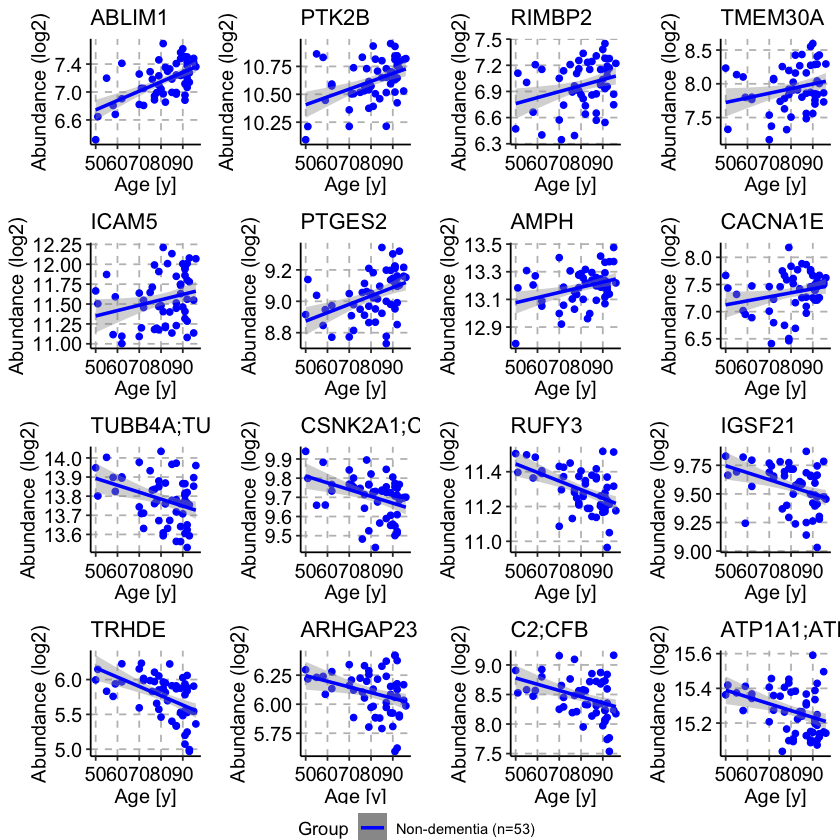

In [115]:
p_for_main_paper <- plot_grid(plotlist = age_protein_plot[1:16], 
               ncol = 4, align = "vh", axis = "lrtb")

p_with_legend_for_main_paper <- plot_grid(
  p_for_main_paper, age_protein_plot[[17]],
  ncol = 1,
  # rel_heights values control vertical title margins
  rel_heights = c(1, 0.03)
)
p_with_legend_for_main_paper


In [116]:
save_plot("100_plus_plots/proteomics/Age_selected_16_for_main_paper - 20230413.pdf", 
          p_with_legend_for_main_paper, limitsize = FALSE,
          base_height = 10, base_width = 12)

In [55]:
#lm_index_s11 <- lm_index
#
#x <- list(index_10 = lm_index_s10, 
#          #index_10bs = lm_index_s10_bs, 
#          index_11bs = lm_index_s11)
#
##path <- "100_plus_plots/proteomics/overlap_pathology_and_aging_protein_lm.png"
#p <- venn.diagram(x, filename = NULL, fill=c('#E41A1C', '#377EB8'),#, "green"),
#             category.names=c("index_10","index_11bs"#,"index_11bs"
#                             ), lwd = 0, alpha = 0.5, 
#                  cat.dist=c(-0.1, -0.04#, -0.04
#                            ),
#             width = 5, height = 5, units = 'in', res = 300)
#grid.draw(p)

In [30]:
#Age_related_proteins_lm <- cbind(rownames(Age_related_proteins_lm), Age_related_proteins_lm)
#colnames(Age_related_proteins_lm) <- c("Protein", "effect_size", "p_value", "adjusted_p_value")

#Age_related_proteins_lm[lm_index, ]

In [14]:
protein_display_dataset <- as.data.frame(fread("/Users/zhangmeng/Documents/Rstudio_workstation/100_plus_protein_viewer/100_plus_protein_viewer/protein_display_dataset.tsv", header =TRUE),
                                         stringsAsFactors=F)

In [30]:
Age_related_proteins_lm$Name <- sapply(Age_related_proteins_lm$Protein, function(x){
    return(protein_display_dataset[which(protein_display_dataset$protein == x), ]$NAME)
})

In [31]:
Age_related_proteins_lm$genesymbol <- sapply(Age_related_proteins_lm$Protein, function(x){
    return(protein_display_dataset[which(protein_display_dataset$protein == x), ]$genesymbol)
})

In [43]:
Age_related_proteins_lm

effect_size   p_value      adjusted_p_value
SLC12A2                            -1.647547e-02 6.647424e-08 0.0002292032    
CASKIN1                            -3.661861e-04 7.673185e-01 1.0000000000    
GNG2                                5.278487e-03 3.431101e-02 1.0000000000    
CARNS1                             -3.059367e-02 1.316565e-05 0.0453951576    
FH                                  5.221021e-03 1.773679e-01 1.0000000000    
EFHD2                               2.551017e-04 9.702510e-01 1.0000000000    
PCLO                               -3.476171e-03 3.428858e-01 1.0000000000    
HSPA1A;HSPA1B                      -7.918349e-04 6.260227e-01 1.0000000000    
STIP1                               1.457936e-02 8.936037e-02 1.0000000000    
CTNND1                             -8.325973e-03 2.013268e-04 0.6941749071    
INPP5A                              4.286378e-03 3.078306e-04 1.0000000000    
SEPT11                              6.092288e-03 9.979529e-02 1.0000000000    
PKP4                                3.322832e-03 9.768538e-02 1.0000000000    
RYR2                                1.797479e-04 7.909752e-01 1.0000000000    
PTPRK                              -4.708039e-03 1.437382e-01 1.0000000000    
CAMKV                               3.163685e-03 5.765856e-02 1.0000000000    
BCR                                 2.552742e-03 5.208074e-03 1.0000000000    
NDUFV2                              1.523700e-03 5.857756e-01 1.0000000000    
IDH3B                              -1.980236e-03 5.547552e-01 1.0000000000    
FMNL2                              -1.036655e-02 9.930887e-05 0.3424169845    
SYT12                              -3.669275e-03 2.203632e-02 1.0000000000    
GRHPR                               3.205257e-05 9.963900e-01 1.0000000000    
CSE1L                              -4.068124e-03 7.141221e-02 1.0000000000    
DNAJC6                             -1.042566e-03 3.025297e-01 1.0000000000    
DUSP3                              -4.899784e-03 4.525654e-01 1.0000000000    
VDAC3                               1.179552e-03 3.503560e-01 1.0000000000    
PITPNM3                             1.506589e-03 4.481082e-01 1.0000000000    
SRPK2                              -3.063335e-04 8.183213e-01 1.0000000000    
AP2A1                               6.551920e-04 3.314652e-01 1.0000000000    
RCN1                                8.903590e-03 4.254435e-02 1.0000000000    
⋮                                  ⋮             ⋮            ⋮               
KLC1;KLC2;KLC4                      0.0017102605 2.686959e-01 1.0000000       
TM9SF3                             -0.0011628138 7.528988e-01 1.0000000       
PLEKHA6                             0.0101602991 1.169861e-01 1.0000000       
KCTD12;KCTD16                       0.0017305627 4.765663e-02 1.0000000       
SLC16A7                            -0.0055485838 1.081890e-01 1.0000000       
PPP3CA;PPP3CB;PPP3CC                0.0129996459 2.118623e-02 1.0000000       
EHD3;EHD4                          -0.0047135446 1.509419e-02 1.0000000       
PEX14                               0.0185652445 1.675053e-03 1.0000000       
TUBB;TUBB4A;TUBB4B                 -0.0022357894 1.590974e-02 1.0000000       
TUBA1A;TUBA1B;TUBA1C;TUBA4A;TUBAL3  0.0090219985 2.293123e-02 1.0000000       
PTPRD;PTPRF                        -0.0026922785 1.801353e-02 1.0000000       
H1F0                               -0.0047789825 1.359401e-01 1.0000000       
FAM210A                            -0.0015944698 2.109874e-01 1.0000000       
EPB41;EPB41L1;EPB41L3               0.0077171917 6.297024e-05 0.2171214       
PABPN1                              0.0023087408 4.133849e-01 1.0000000       
KCND2;KCND3                        -0.0006080975 6.881040e-01 1.0000000       
JMJD7;PLA2G4B                       0.0113379196 2.424306e-01 1.0000000       
U2AF1;U2AF1L4;U2AF1L5               0.0018905618 2.841240e-01 1.0000000       
ATP6V1G1;ATP6V1G2                   0.0072424733 3.779535e-05 0.1303184       
ATP5J2

In [42]:
Age_related_proteins_lm$pure_age <- NA

In [33]:
save_data <- Age_related_proteins_lm[lm_index, ][, c(1, 6, 5, 2, 3, 4)]

In [34]:
save_data[order(save_data$adjusted_p_value), ]

Protein                 genesymbol
ABLIM1                  ABLIM1                  ABLIM1    
IGSF21                  IGSF21                  IGSF21    
RPS16                   RPS16                   RPS16     
ATP2B4                  ATP2B4                  ATP2B4    
GRM3                    GRM3                    GRM3      
SIRT2                   SIRT2                   SIRT2     
MOG                     MOG                     MOG       
CIT                     CIT                     CIT       
CNP                     CNP                     CNP       
ICAM5                   ICAM5                   ICAM5     
RPL11                   RPL11                   RPL11     
RAP1GDS1                RAP1GDS1                RAP1GDS1  
GLTP                    GLTP                    GLTP      
PIP4K2A;PIP4K2B         PIP4K2A;PIP4K2B         PIP4K2A   
PTK2B                   PTK2B                   PTK2B     
RAB33B                  RAB33B                  RAB33B    
ATP1A2                  ATP1A2                  ATP1A2    
CSNK2A1;CSNK2A3         CSNK2A1;CSNK2A3         CSNK2A1   
SSB                     SSB                     SSB       
MAP1B                   MAP1B                   MAP1B     
NCKAP1;NCKAP1L          NCKAP1;NCKAP1L          NCKAP1    
ALCAM                   ALCAM                   ALCAM     
RPSA                    RPSA                    RPSA      
UBAP2L                  UBAP2L                  UBAP2L    
PLP1                    PLP1                    PLP1      
SLC44A1                 SLC44A1                 SLC44A1   
AMPH                    AMPH                    AMPH      
USP7                    USP7                    USP7      
TRHDE                   TRHDE                   TRHDE     
NPTX1                   NPTX1                   NPTX1     
⋮                       ⋮                       ⋮         
API5                    API5                    API5      
TANC2                   TANC2                   TANC2     
DDX5                    DDX5                    DDX5      
SCN3B                   SCN3B                   SCN3B     
MAPK10;MAPK8;MAPK9      MAPK10;MAPK8;MAPK9      MAPK10    
SHANK1                  SHANK1                  SHANK1    
PPP2CB                  PPP2CB                  PPP2CB    
NIPSNAP3B               NIPSNAP3B               NIPSNAP3B 
RALA;RALB               RALA;RALB               RALA      
HSP90AA1;HSP90AB1       HSP90AA1;HSP90AB1       HSP90AA1  
STX5                    STX5                    STX5      
IRAK2                   IRAK2                   IRAK2     
RRAGC;RRAGD             RRAGC;RRAGD             RRAGC     
FABP5                   FABP5                   FABP5     
RAB14                   RAB14                   RAB14     
GRM1                    GRM1                    GRM1      
GK2                     GK2                     GK2       
PSMD7                   PSMD7                   PSMD7     
YWHAB;YWHAG;YWHAH;YWHAZ YWHAB;YWHAG;YWHAH;YWHAZ YWHAB     
AIFM3                   AIFM3                   AIFM3     
PRDX6                   PRDX6                   PRDX6     
HOOK3                   HOOK3                   HOOK3     
HABP4                   HABP4                   HABP4     
HSPA12B                 HSPA12B                 HSPA12B   
DPP10                   DPP10                   DPP10     
ERAP1                   ERAP1                   ERAP1     
EIF4G2                  EIF4G2                  EIF4G2    
CACNA2D2                CACNA2D2                CACNA2D2  
ATP6V1H                 ATP6V1H                 ATP6V1H   
MACROD1                 MACROD1                 MACROD1   
                        Name                                                                  
ABLIM1                  Actin-binding LIM protein 1                                           
IGSF21                  Immunoglobulin superfamily member 21                                  
RPS16                   40S ribosomal protein S16                                

In [96]:
write.table(save_data[order(save_data$adjusted_p_value), ], 
            "100_plus_results/Age_related_protein/New_Age_protein_lm_test.tsv", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [15]:
save_data <- as.data.frame(fread("100_plus_results/Age_related_protein/New_Age_protein_lm_test.tsv"), stringsAsFactors=F)

In [16]:
save_data

Protein                
1   ABLIM1                 
2   IGSF21                 
3   RPS16                  
4   ATP2B4                 
5   GRM3                   
6   SIRT2                  
7   MOG                    
8   CIT                    
9   CNP                    
10  ICAM5                  
11  RPL11                  
12  RAP1GDS1               
13  GLTP                   
14  PIP4K2A;PIP4K2B        
15  PTK2B                  
16  RAB33B                 
17  ATP1A2                 
18  CSNK2A1;CSNK2A3        
19  SSB                    
20  MAP1B                  
21  NCKAP1;NCKAP1L         
22  ALCAM                  
23  RPSA                   
24  UBAP2L                 
25  PLP1                   
26  SLC44A1                
27  AMPH                   
28  USP7                   
29  TRHDE                  
30  NPTX1                  
⋮   ⋮                      
358 API5                   
359 TANC2                  
360 DDX5                   
361 SCN3B                  
362 MAPK10;MAPK8;MAPK9     
363 SHANK1                 
364 PPP2CB                 
365 NIPSNAP3B              
366 RALA;RALB              
367 HSP90AA1;HSP90AB1      
368 STX5                   
369 IRAK2                  
370 RRAGC;RRAGD            
371 FABP5                  
372 RAB14                  
373 GRM1                   
374 GK2                    
375 PSMD7                  
376 YWHAB;YWHAG;YWHAH;YWHAZ
377 AIFM3                  
378 PRDX6                  
379 HOOK3                  
380 HABP4                  
381 HSPA12B                
382 DPP10                  
383 ERAP1                  
384 EIF4G2                 
385 CACNA2D2               
386 ATP6V1H                
387 MACROD1                
    Name                                                                  
1   Actin-binding LIM protein 1                                           
2   Immunoglobulin superfamily member 21                                  
3   40S ribosomal protein S16                                             
4   Plasma membrane calcium-transporting ATPase 4                         
5   Metabotropic glutamate receptor 3                                     
6   NAD-dependent protein deacetylase sirtuin-2                           
7   Myelin-oligodendrocyte glycoprotein                                   
8   Citron Rho-interacting kinase                                         
9   2',3'-cyclic-nucleotide 3'-phosphodiesterase                          
10  Intercellular adhesion molecule 5                                     
11  60S ribosomal protein L11                                             
12  Rap1 GTPase-GDP dissociation stimulator 1                             
13  Glycolipid transfer protein                                           
14  Phosphatidylinositol 5-phosphate 4-kinase type-2 alpha                
15  Protein-tyrosine kinase 2-beta                                        
16  Ras-related protein Rab-33B                                           
17  Sodium/potassium-transporting ATPase subunit alpha-2                  
18  Casein kinase II subunit alpha                                        
19  Lupus La protein                                                      
20  Microtubule-associated protein 1B                                     
21  Nck-associated protein 1                                              
22  CD166 antigen                                                         
23  40S ribosomal protein SA                                              
24  Ubiquitin-associated protein 2-like                                   
25  Myelin proteolipid protein                                            
26  Choline transporter-like protein 1                                    
27  Amphiphysin                                                           
28  Ubiquitin carboxyl-terminal hydrolase 7                               
29  Thyrotropin-releasing hormone-degrading ectoenzyme                    
30  Neuronal pentr

In [27]:
save(Age_related_proteins_lm, file="Age_related_proteins_lm.Rdata")

In [109]:
load(file="Age_related_proteins_lm.Rdata")

In [110]:
Age_related_proteins_sig <- Age_related_proteins_lm[Age_related_proteins_lm$adjusted_p_value < 0.05, ]

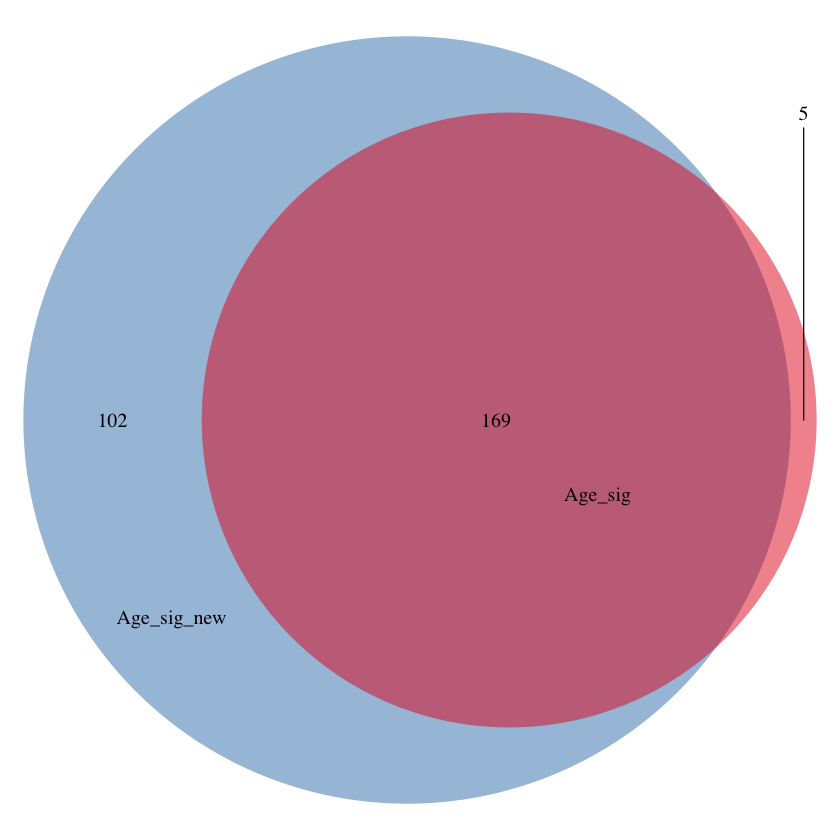

In [111]:
x <- list(Age_sig = rownames(Age_related_proteins_sig), 
          Age_sig_new = rownames(Age_related_proteins_lm[lm_index, ]))

#path <- "100_plus_plots/proteomics/overlap_pathology_and_aging_protein_lm.png"
p <- venn.diagram(x, filename = NULL, fill=c('#E41A1C', '#377EB8'),
             category.names=c("Age_sig","Age_sig_new"), lwd = 0, alpha = 0.5, cat.dist=c(-0.1, -0.04),
             width = 5, height = 5, units = 'in', res = 300)
grid.draw(p)

In [42]:
protein = rownames(Age_related_proteins_lm)
Age_related_proteins_lm <- cbind(protein, Age_related_proteins_lm)

In [43]:
Age_related_proteins_lm$sig <- FALSE

In [44]:
Age_related_proteins_lm[which(Age_related_proteins_lm$adjusted_p_value<0.05), ]$sig <- TRUE

In [45]:
write.table(Age_related_proteins_lm, 
            "100_plus_results/Age_related_protein/Age_protein_lm_test_results.tsv", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [46]:
write.table(Age_related_proteins_lm[lm_index, ], 
            "100_plus_results/Age_related_protein/Age_protein_sig_list.tsv", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [36]:
Age_related_proteins_lm$protein <- rownames(Age_related_proteins_lm)
Age_related_proteins_lm$idx <- 1:nrow(Age_related_proteins_lm)

In [32]:
Age_related_proteins_lm

effect_size   p_value      adjusted_p_value
SLC12A2                            -1.647861e-02 6.620018e-08 0.0002354079    
CASKIN1                            -3.703830e-04 7.648336e-01 1.0000000000    
GNG2                                5.276674e-03 3.446790e-02 1.0000000000    
CARNS1                             -3.059107e-02 1.307337e-05 0.0464889197    
FH                                  5.211527e-03 1.783670e-01 1.0000000000    
EFHD2                               2.317002e-04 9.730077e-01 1.0000000000    
PCLO                               -3.481546e-03 3.421395e-01 1.0000000000    
HSPA1A;HSPA1B                      -8.006697e-04 6.232345e-01 1.0000000000    
STIP1                               1.455228e-02 9.028354e-02 1.0000000000    
CTNND1                             -8.333448e-03 1.996591e-04 0.7099878871    
INPP5A                              4.283575e-03 3.111945e-04 1.0000000000    
SEPT11                              6.087347e-03 1.002562e-01 1.0000000000    
PKP4                                3.314213e-03 9.840437e-02 1.0000000000    
RYR2                                1.749423e-04 7.961458e-01 1.0000000000    
PTPRK                              -4.723157e-03 1.416982e-01 1.0000000000    
CAMKV                               3.162900e-03 5.779840e-02 1.0000000000    
BCR                                 2.545961e-03 5.244516e-03 1.0000000000    
NDUFV2                              1.516024e-03 5.879572e-01 1.0000000000    
IDH3B                              -1.992954e-03 5.524719e-01 1.0000000000    
FMNL2                              -1.036980e-02 9.867940e-05 0.3509039559    
SYT12                              -3.676299e-03 2.193834e-02 1.0000000000    
GRHPR                               8.580591e-06 9.990347e-01 1.0000000000    
CSE1L                              -4.066138e-03 7.145688e-02 1.0000000000    
DNAJC6                             -1.043637e-03 3.022216e-01 1.0000000000    
DUSP3                              -4.911471e-03 4.516552e-01 1.0000000000    
VDAC3                               1.178667e-03 3.510807e-01 1.0000000000    
PITPNM3                             1.501364e-03 4.489195e-01 1.0000000000    
TP53BP1                             8.939882e-03 3.799519e-04 1.0000000000    
SRPK2                              -3.099289e-04 8.165579e-01 1.0000000000    
AP2A1                               6.541388e-04 3.322432e-01 1.0000000000    
⋮                                  ⋮             ⋮            ⋮               
KLC1;KLC2;KLC4                      0.0017058053 2.703995e-01 1.00000000      
TM9SF3                             -0.0011610824 7.534299e-01 1.00000000      
PLEKHA6                             0.0101537256 1.171419e-01 1.00000000      
KCTD12;KCTD16                       0.0017287674 4.766357e-02 1.00000000      
SLC16A7                            -0.0055554316 1.076651e-01 1.00000000      
PPP3CA;PPP3CB;PPP3CC                0.0129856330 2.139394e-02 1.00000000      
EHD3;EHD4                          -0.0047149255 1.500051e-02 1.00000000      
PEX14                               0.0185439610 1.687559e-03 1.00000000      
TUBB;TUBB4A;TUBB4B                 -0.0022336361 1.616343e-02 1.00000000      
TUBA1A;TUBA1B;TUBA1C;TUBA4A;TUBAL3  0.0090211962 2.301439e-02 1.00000000      
PTPRD;PTPRF                        -0.0027023144 1.755940e-02 1.00000000      
H1F0                               -0.0048020315 1.347514e-01 1.00000000      
FAM210A                            -0.0015943597 2.115138e-01 1.00000000      
EPB41;EPB41L1;EPB41L3               0.0077129495 6.416746e-05 0.22817949      
PABPN1                              0.0023075466 4.137714e-01 1.00000000      
KCND2;KCND3                        -0.0006091360 6.876835e-01 1.00000000      
JMJD7;PLA2G4B                       0.0113342287 2.428178e-01 1.00000000      
U2AF1;U2AF1L4;U2AF1L5               0.0018870895 2.845510e-01 1.00000000      
ATP6V1G1;ATP6V1G2                   0.0072381006 3.806639e-05 0.13536409      
ATP5J2

In [32]:
write.table(Age_related_proteins_lm[lm_index, ], 
            "100_plus_results/Age_related_protein/Age_protein_with_idx.tsv", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [80]:
write.table(data.frame(index = lm_index, protein = rownames(Age_related_proteins_lm[lm_index,])), 
            "R_workstation/100_plus_key_driven_protein/age_related_protein_175.txt", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

[1] 1256


Call:
lm(formula = re ~ exp, data = lm_data)

Coefficients:
(Intercept)          exp  
    13.5209      -0.0277  


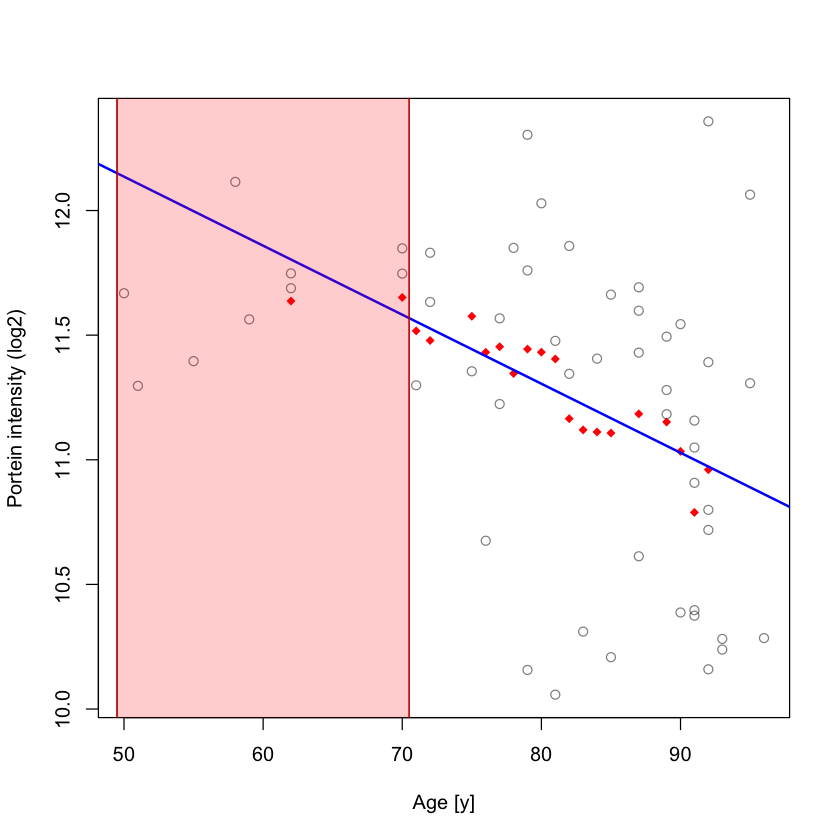

In [31]:
which(rownames(Age_related_proteins_lm) == "SIRT2")

lm_data <- data.frame(re=as.numeric(mean_intens_perage[1256,]), exp=as.numeric(single_age))
fit_lm <- lm(re~exp, data = lm_data)
fit_lm

#pdf("Temp_results/average_expression_with_sliding_window.pdf")
plot(x = metadata[Age_test_index, ]$age, y = protein_intensity_combat[1256, ][Age_test_index], 
     xlab = "Age [y]", ylab = "Portein intensity (log2)", col=rgb(red=0, green=0, blue=0, alpha=0.5))
points(x = single_age, y = mean_intens_perage[1256,], pch=18, col=rgb(red=1, green=0, blue=0, alpha=1))
abline(fit_lm, col = "blue", lwd = 2)
polygon(x = c(49.5, 49.5, 70.5, 70.5),
        y = c(9.9, 13.0, 13.0, 9.9), col = rgb(1, 0, 0, 0.2))
abline(v = 49.5, col = "red", lwd = 1)
abline(v = 70.5, col = "red", lwd = 1)
#dev.off()

In [32]:
plot_data <- data.frame(age = metadata[Age_test_index, ]$age, 
                        intens = protein_intensity_combat[1256, ][Age_test_index],
                        type = "raw")
avg_data <- data.frame(age = single_age, 
                       intens = mean_intens_perage[1256,], 
                       type = "avg")

In [33]:
plot_data <- rbind(plot_data, avg_data)

In [36]:
ploygon <- data.frame(x = c(49.5, 49.5, 72.5, 72.5),
                      y = c(9.9, 13.0, 13.0, 9.9))

In [41]:
pdf("100_plus_plots/proteomics/average_expression_with_sliding_window-20270721.pdf", 
     width = 6, height = 5)
ggplot() + 
    geom_point(aes(x = age, y = intens), data = subset(plot_data, type == "raw"),  
               shape = 16, color = "black",
               size = 2, alpha = 0.3) +
    geom_rect(aes(xmin = 50, xmax = 72, ymin = -Inf, ymax = Inf),
              fill = "pink", alpha = 0.5) +
    geom_vline(xintercept = 50, col = "red", lwd = 0.5) + 
    geom_vline(xintercept = 72, col = "red", lwd = 0.5) +
    geom_point(aes(x = age, y = intens), data = subset(plot_data, type == "avg"),
               shape = 16, color = "red", size = 2, alpha = 0.8) +
    xlab("Age [y]") + ylab("Log2 abundance of SIRT2 protein") +
    geom_smooth(method='lm', formula = y~x, aes(x = age, y = intens),  fullrange = TRUE,
                data = subset(plot_data, type = "avg")) +
    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Vertical major grid lines
          panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Horizontal major grid lines
          panel.grid.minor.x = element_line(), # Vertical minor grid lines
          panel.grid.minor.y = element_line(),  # Vertical major grid lines
          
          legend.position = "right",
          legend.direction = "vertical",
          
          legend.text = element_text(size = 10, color = "black", face = "bold"),
          
          axis.text.x = element_text(size = 8, color = "black", face = "bold", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = 8, color = "black", face = "bold"),
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black"))
dev.off()

pdf 
  2

In [32]:
####################Braak stage related proteins analysis#################

In [43]:
Braak_test_index <- which((metadata$GROUP != "CHC") )#& (metadata$age < 100))
length(Braak_test_index)

protein_intensity_combat_nonlog <- 2^protein_intensity_combat

[1] 141

In [44]:
pathology_related_proteins_lm <- as.data.frame(t(apply(protein_intensity_combat[, Braak_test_index], 1, 
                                                       lm_sig_test, metadata[Braak_test_index,]$fBraak)))
colnames(pathology_related_proteins_lm) <- c("effect_size", "p_value")
pathology_related_proteins_lm$adjusted_p_value <- p.adjust(pathology_related_proteins_lm$p_value, 
                                                              method="BH")

In [45]:
pathology_sig_index <- which(pathology_related_proteins_lm$adjusted_p_value < 0.05)

In [46]:
length(pathology_sig_index)

[1] 2378

In [116]:
x <- list(Braak_sig = pathology_sig_index, 
          Age_sig = lm_index)

path <- "100_plus_plots/proteomics/overlap_pathology_and_aging_protein_lm.png"
p <- venn.diagram(x, filename = path, imagetype = "png", fill=c('#E41A1C', '#377EB8'),
             category.names=c("Braak stage related proteins","Age related proteins"), lwd = 0, alpha = 0.5, cat.dist=c(-0.1, -0.04),
             width = 5, height = 5, units = 'in', res = 300)
#grid.draw(p)

In [47]:
pure_sig_age_index <- setdiff(lm_index, pathology_sig_index)

In [48]:
age_Braak_sig_idx <- setdiff(lm_index, pure_sig_age_index)

In [49]:
length(pure_sig_age_index)
length(age_Braak_sig_idx)

[1] 60

[1] 114

In [44]:
colnames(Age_related_proteins_lm) <- c(paste("Aging", colnames(Age_related_proteins_lm), sep="_"))

In [51]:
Age_related_proteins_lm$pure_age <- "no"

In [52]:
Age_related_proteins_lm[pure_sig_age_index, ]$pure_age <- "yes"

In [54]:
Age_related_proteins_lm$age_braak <- "no"

In [55]:
Age_related_proteins_lm[age_Braak_sig_idx, ]$age_braak <- "yes"

In [56]:
save(Age_related_proteins_lm, file="Age_related_proteins_lm_results.Rdata")

In [43]:
Age_related_proteins_lm[pure_sig_age_index, ]$pure_age <- TRUE
Age_related_proteins_lm[age_Braak_sig_idx, ]$pure_age <- FALSE

In [48]:
save_data <- Age_related_proteins_lm[lm_index, ][, c(1, 6, 5, 2, 3, 4, 7)]

In [49]:
save_data

Protein                           
SLC12A2                            SLC12A2                           
CARNS1                             CARNS1                            
INPP5A                             INPP5A                            
FMNL2                              FMNL2                             
MAP1B                              MAP1B                             
SLC16A1                            SLC16A1                           
IRGQ                               IRGQ                              
NAPA                               NAPA                              
AP1B1;AP2B1                        AP1B1;AP2B1                       
SV2A                               SV2A                              
NFASC                              NFASC                             
MTHFD1                             MTHFD1                            
APOE                               APOE                              
HSPA12A                            HSPA12A                           
FLOT1                              FLOT1                             
C3                                 C3                                
KBTBD11                            KBTBD11                           
ATP1A2                             ATP1A2                            
PITPNB                             PITPNB                            
AMPH                               AMPH                              
BIN1                               BIN1                              
ATP1A1;ATP1A3                      ATP1A1;ATP1A3                     
RAB14                              RAB14                             
HSP90AA1;HSP90AB1;HSP90AB2P        HSP90AA1;HSP90AB1;HSP90AB2P       
SHANK2                             SHANK2                            
HADHA                              HADHA                             
PGM1                               PGM1                              
PACSIN2                            PACSIN2                           
RPS6KA2;RPS6KA3                    RPS6KA2;RPS6KA3                   
RPS14                              RPS14                             
⋮                                  ⋮                                 
RPL31                              RPL31                             
INA;NEFH;NEFL;NEFM                 INA;NEFH;NEFL;NEFM                
NPTXR                              NPTXR                             
WRN                                WRN                               
ROBO2                              ROBO2                             
RGS7BP                             RGS7BP                            
NCKAP1;NCKAP1L                     NCKAP1;NCKAP1L                    
RPL27                              RPL27                             
ARHGAP23                           ARHGAP23                          
YWHAB;YWHAG;YWHAH;YWHAZ            YWHAB;YWHAG;YWHAH;YWHAZ           
SLC7A14                            SLC7A14                           
PIGK                               PIGK                              
CLDN11                             CLDN11                            
CCT6A;CCT6B                        CCT6A;CCT6B                       
CHMP4B                             CHMP4B                            
NIPSNAP3B                          NIPSNAP3B                         
FXYD7                              FXYD7                             
DCX                                DCX                               
GRM1                               GRM1                              
UQCRH;UQCRHL                       UQCRH;UQCRHL                      
AGPAT1                             AGPAT1                            
SMCR8                              SMCR8                             
RAP2A                              RAP2A                             
SYPL1                              SYPL1                             
RPL11                              RPL11                             
DNAJB1;DNAJB4                      DNAJB1;DNA

In [35]:
cell_type_matrix$slope <- Age_related_proteins_lm$effect_size

In [42]:
cell_type_matrix[setdiff(lm_index, pure_sig_age_index), ][, c(1, 2, 3, 5)]

protein                            genesymbol HUGO_gene slope       
1    SLC12A2                            SLC12A2    SLC12A2   -0.016475472
35   MAP1B                              MAP1B      MAP1B     -0.007200298
62   IRGQ                               IRGQ       IRGQ      -0.012766274
124  MTHFD1                             MTHFD1     MTHFD1     0.005406671
167  HSPA12A                            HSPA12A    HSPA12A   -0.005648299
200  ATP1A2                             ATP1A2     ATP1A2    -0.005950950
232  ATP1A1;ATP1A3                      ATP1A1     ATP1A1    -0.005284961
246  SHANK2                             SHANK2     SHANK2    -0.011159894
250  HADHA                              HADHA      HADHA     -0.006187667
256  RPS6KA2;RPS6KA3                    RPS6KA2    RPS6KA2    0.007484040
274  CIT                                CIT        CIT        0.009007322
332  RPS3                               RPS3       RPS3      -0.003474713
336  TPD52L1                            TPD52L1    TPD52L1    0.016131524
357  RALA                               RALA       RALA      -0.005005557
408  RPLP0;RPLP0P6                      RPLP0      RPLP0     -0.004511632
414  RRAGC;RRAGD                        RRAGC      RRAGC      0.007790624
480  TRHDE                              TRHDE      TRHDE     -0.017554158
489  GSTK1                              GSTK1      GSTK1     -0.004336327
495  RPL22                              RPL22      RPL22     -0.004201671
533  ANXA11                             ANXA11     ANXA11    -0.018309317
550  ATP1A1;ATP1A2;ATP1A3               ATP1A1     ATP1A1    -0.004502836
631  RPSA                               RPSA       RPSA      -0.006577541
657  DYNC1I1                            DYNC1I1    DYNC1I1   -0.004243320
671  CCT3                               CCT3       CCT3      -0.002246844
673  SCN2A                              SCN2A      SCN2A     -0.012110083
677  SGTB                               SGTB       SGTB      -0.012011857
686  INA                                INA        INA       -0.014915615
712  ALCAM                              ALCAM      ALCAM     -0.010467665
730  ANXA6                              ANXA6      ANXA6     -0.005694018
786  CCT6A                              CCT6A      CCT6A     -0.003339021
⋮    ⋮                                  ⋮          ⋮         ⋮           
2444 PCSK1                              PCSK1      PCSK1      0.012491470
2486 ENTPD3                             ENTPD3     ENTPD3     0.010000343
2536 NT5E                               NT5E       NT5E      -0.011672687
2538 MAP3K5                             MAP3K5     MAP3K5     0.016814907
2621 RIMBP2                             RIMBP2     RIMBP2     0.009654341
2694 CCT6B                              CCT6B      CCT6B     -0.003324397
2708 RPS13                              RPS13      RPS13     -0.005580521
2712 GLMN                               GLMN       GLMN      -0.005719628
2720 RUFY3                              RUFY3      RUFY3     -0.004796571
2730 KCNA1;KCNA2;KCNA3                  KCNA1      KCNA1     -0.011445273
2737 SLC2A13                            SLC2A13    SLC2A13    0.014335160
2762 SSB                                SSB        SSB        0.006328429
2830 DIP2A;DIP2C                        DIP2A      DIP2A     -0.008632643
2870 GLTP                               GLTP       GLTP      -0.028280878
2923 ILF2                               ILF2       ILF2       0.005422048
2937 ELAVL2                             ELAVL2     ELAVL2    -0.016234480
2938 ELAVL3;ELAVL4                      ELAVL3     ELAVL3    -0.008163046
2955 RAP1A;RAP1B                        RAP1A      RAP1A     -0.006959819
3091 WASH2P;WASH3P;WASH4P;WASH6P;WASHC1 WASH2P     WASH2P    -0.010221230
3151 VPS25                              VPS25      VPS25     -0.008104773
3164 ITGB4                              ITGB4      ITGB4      0.015578798
3211 LINGO1                             LINGO1     LINGO1    -0.008097318
3281 WRN 

In [43]:
write.table(cell_type_matrix[pure_sig_age_index, ][, c(1, 2, 3, 5)], 
            "100_plus_results/Age_related_protein/Age_protein_60.txt", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [44]:
write.table(cell_type_matrix[setdiff(lm_index, pure_sig_age_index), ][, c(1, 2, 3, 5)], 
            "100_plus_results/Age_related_protein/Age_protein_114.txt", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [45]:
write.table(cell_type_matrix[lm_index, ][, c(1, 2, 3, 5)], 
            "100_plus_results/Age_related_protein/Age_protein_174.txt", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [45]:
write.table(cell_type_matrix[, c(1, 2, 3)], 
            "100_plus_results/background_proteins.txt", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

#### For online APP, generate dataset 

In [35]:
protein_display_dataset <- as.data.frame(fread("/Users/zhangmeng/Documents/Rstudio_workstation/100_plus_protein_viewer/100_plus_protein_viewer/protein_display_dataset.tsv", header =TRUE),
                                                    stringsAsFactors=F)

In [36]:
protein_display_dataset$age_adj_p <- Age_related_proteins_lm$adjusted_p_value
protein_display_dataset$effect_size <- Age_related_proteins_lm$effect_size
protein_display_dataset$age_sig <- 0
protein_display_dataset[pure_sig_age_index, ]$age_sig <- 1

In [37]:
write.table(protein_display_dataset, "/Users/zhangmeng/Documents/Rstudio_workstation/100_plus_protein_viewer/100_plus_protein_viewer/protein_display_dataset.tsv", sep = "\t", row.names = FALSE, quote = FALSE)

In [50]:
labeled_proteins <- rownames(Age_related_proteins_lm[c(pure_sig_age_index, 
                                                       setdiff(lm_index, pure_sig_age_index)), ])
multiple_names <- labeled_proteins[grep(";", labeled_proteins)]

In [51]:
multiple_names <- data.frame(protein=multiple_names, label="", stringsAsFactors = FALSE)

In [52]:
multiple_names

protein                            label
1  PDPK1;PDPK2P                            
2  RAB11A;RAB11B                           
3  C2;CFB                                  
4  PIP4K2A;PIP4K2B                         
5  PDE1A;PDE1C                             
6  INA;NEFH;NEFL;NEFM;VIM                  
7  CAND1;CAND2                             
8  INA;NEFH;NEFL;NEFM                      
9  NCKAP1;NCKAP1L                          
10 DNAJB1;DNAJB4                           
11 ATP1A1;ATP1A3                           
12 RPS6KA2;RPS6KA3                         
13 RPLP0;RPLP0P6                           
14 RRAGC;RRAGD                             
15 ATP1A1;ATP1A2;ATP1A3                    
16 TUBB3;TUBB4A;TUBB4B                     
17 MAP1A;MAP1B                             
18 TUBB4A;TUBB4B;TUBB8                     
19 PTPRD;PTPRS                             
20 ELAVL2;ELAVL3;ELAVL4                    
21 CSNK2A1;CSNK2A3                         
22 ELAVL2;ELAVL4                           
23 TUBB3;TUBB6                             
24 KCNA1;KCNA2;KCNA3                       
25 DIP2A;DIP2C                             
26 ELAVL3;ELAVL4                           
27 RAP1A;RAP1B                             
28 WASH2P;WASH3P;WASH4P;WASH6P;WASHC1      
29 CCT6A;CCT6B

In [53]:
used_labels <- dict()

for(i in 1:nrow(multiple_names)){
    name <- unlist(str_split(multiple_names[i, ]$protein, ";"))[1]
    if(name %in% used_labels$keys()){
        multiple_names[i, ]$label <- paste(name, used_labels[[name]]+1, sep="")
        used_labels[[name]] <- used_labels[[name]] + 1
    }
    else{
        multiple_names[i, ]$label <- paste(name, "1", sep="")
        used_labels[[name]] <- 1
    }
}

In [54]:
multiple_names

protein                            label   
1  PDPK1;PDPK2P                       PDPK11  
2  RAB11A;RAB11B                      RAB11A1 
3  C2;CFB                             C21     
4  PIP4K2A;PIP4K2B                    PIP4K2A1
5  PDE1A;PDE1C                        PDE1A1  
6  INA;NEFH;NEFL;NEFM;VIM             INA1    
7  CAND1;CAND2                        CAND11  
8  INA;NEFH;NEFL;NEFM                 INA2    
9  NCKAP1;NCKAP1L                     NCKAP11 
10 DNAJB1;DNAJB4                      DNAJB11 
11 ATP1A1;ATP1A3                      ATP1A11 
12 RPS6KA2;RPS6KA3                    RPS6KA21
13 RPLP0;RPLP0P6                      RPLP01  
14 RRAGC;RRAGD                        RRAGC1  
15 ATP1A1;ATP1A2;ATP1A3               ATP1A12 
16 TUBB3;TUBB4A;TUBB4B                TUBB31  
17 MAP1A;MAP1B                        MAP1A1  
18 TUBB4A;TUBB4B;TUBB8                TUBB4A1 
19 PTPRD;PTPRS                        PTPRD1  
20 ELAVL2;ELAVL3;ELAVL4               ELAVL21 
21 CSNK2A1;CSNK2A3                    CSNK2A11
22 ELAVL2;ELAVL4                      ELAVL22 
23 TUBB3;TUBB6                        TUBB32  
24 KCNA1;KCNA2;KCNA3                  KCNA11  
25 DIP2A;DIP2C                        DIP2A1  
26 ELAVL3;ELAVL4                      ELAVL31 
27 RAP1A;RAP1B                        RAP1A1  
28 WASH2P;WASH3P;WASH4P;WASH6P;WASHC1 WASH2P1 
29 CCT6A;CCT6B                        CCT6A1

In [55]:
for(i in 1:nrow(multiple_names)){
    cat(multiple_names[i,]$label, end=": ", sep="")
    cat(multiple_names[i,]$protein, end=", ", sep="")
}

PDPK11: PDPK1;PDPK2P, RAB11A1: RAB11A;RAB11B, C21: C2;CFB, PIP4K2A1: PIP4K2A;PIP4K2B, PDE1A1: PDE1A;PDE1C, INA1: INA;NEFH;NEFL;NEFM;VIM, CAND11: CAND1;CAND2, INA2: INA;NEFH;NEFL;NEFM, NCKAP11: NCKAP1;NCKAP1L, DNAJB11: DNAJB1;DNAJB4, ATP1A11: ATP1A1;ATP1A3, RPS6KA21: RPS6KA2;RPS6KA3, RPLP01: RPLP0;RPLP0P6, RRAGC1: RRAGC;RRAGD, ATP1A12: ATP1A1;ATP1A2;ATP1A3, TUBB31: TUBB3;TUBB4A;TUBB4B, MAP1A1: MAP1A;MAP1B, TUBB4A1: TUBB4A;TUBB4B;TUBB8, PTPRD1: PTPRD;PTPRS, ELAVL21: ELAVL2;ELAVL3;ELAVL4, CSNK2A11: CSNK2A1;CSNK2A3, ELAVL22: ELAVL2;ELAVL4, TUBB32: TUBB3;TUBB6, KCNA11: KCNA1;KCNA2;KCNA3, DIP2A1: DIP2A;DIP2C, ELAVL31: ELAVL3;ELAVL4, RAP1A1: RAP1A;RAP1B, WASH2P1: WASH2P;WASH3P;WASH4P;WASH6P;WASHC1, CCT6A1: CCT6A;CCT6B, 

In [31]:
Astrocytes = "#FEB24C"
Endothelial = "#88419D"
Microglia = "#9ECAE1"
ExNeurons = "#ADDD8E"
InNeurons = "#339900"
OPC = "#A50F15"
Oligodendrocytes = "#DD3497"
Unknown = "#008080"
No_unique_enrichment = "#969696"
NS_DEPs = "gray88"

In [32]:
#cell_type_matrix$CELL <- NA
#cell_type_matrix[which(cell_type_matrix$celltype %in% c("ExNeurons", "InNeurons")), ]$CELL <- "Neurons"
#cell_type_matrix[which(cell_type_matrix$celltype %in% c("Oligodendrocytes")), ]$CELL <- "Oligodendrocytes"
#
#cell_type_matrix$O_celltype <- cell_type_matrix$celltype
#cell_type_matrix$celltype <- cell_type_matrix$CELL

In [33]:
table(cell_type_matrix$celltype, useNA = "ifany")


      Astrocytes      Endothelial        ExNeurons        InNeurons 
              61                5               56               19 
       Microglia              OPC Oligodendrocytes          Unknown 
              24               17               61               10 
            <NA> 
            3195 

In [34]:
generate_data_matrix_for_plot <- function(data, sig_index){
    data$gene <- cell_type_matrix$protein
    data$celltype <- cell_type_matrix$celltype
    data[which(data$celltype == "Unknown"), ]$celltype <- NA
    sig_DE_ns_celltype <- sig_index[which(is.na(cell_type_matrix[sig_index, ]$celltype))]
    data[sig_DE_ns_celltype,]$celltype <- "NS_celltype"
    data[-sig_index,]$celltype <- "NS_at_all"

    
    data$alpha <- 1
    data[-sig_index,]$alpha <- 0.2
    
    return(data)
}

In [79]:
plot_volcano_with_cell_enrich <- function(data, sig_index, label_index, xlab, title){
    data_matrix <- generate_data_matrix_for_plot(data, sig_index)
    
    #print(nrow(data_matrix))
    
    labels <- rep(NA, nrow(data_matrix))
    labels[label_index] <- data_matrix[label_index,]$gene
    
    #data_matrix$labels <- labels
    used_labels <- dict()
    
    multiple_names_idx <- grep(";", labels)
    for(i in multiple_names_idx){
        name <- unlist(str_split(labels[i], ";"))[1]
        if(name %in% used_labels$keys()){
            labels[i] <- paste(name, "[", used_labels[[name]]+1, "]", sep="")
            used_labels[[name]] <- used_labels[[name]] + 1
        }
        else{
            labels[i] <- paste(name, "[1]", sep="")
            used_labels[[name]] <- 1
        }
    }
    
    data_matrix$labels <- labels
    #print(data_matrix[multiple_names_idx, ])
    
    data_matrix$celltype <- factor(data_matrix$celltype, 
                                   levels=c("Astrocytes", "Endothelial", "ExNeurons", "InNeurons", 
                                            "Microglia", "OPC", "Oligodendrocytes", "Unknown", 
                                            "NS_celltype", "NS_at_all"))
    
    #print(table(data_matrix$celltype))
    
    #print(table(data_matrix$celltype))
    
    p <- ggplot(data=data_matrix, 
        aes(x=effect_size, y=-log10(adjusted_p_value), col=celltype, label=labels)) +
        
        geom_point(size = 2, alpha = data_matrix$alpha) +
  
        geom_text_repel(size=3, show.legend = FALSE, parse=TRUE, na.rm=TRUE) +
        xlab(xlab) + ylab("-log10(FWER)") + ggtitle(title) +
    
        scale_color_manual(name="Cell type", breaks = c("Astrocytes", "Endothelial", "ExNeurons", "InNeurons", 
                                            "Microglia", "OPC", "Oligodendrocytes", "Unknown", 
                                            "NS_celltype", "NS_at_all"),
                           values = c(Astrocytes, Endothelial, ExNeurons, InNeurons, 
                                                        Microglia, OPC, Oligodendrocytes, Unknown, 
                                                        No_unique_enrichment, NS_DEPs),
                           labels = c("Astrocytes", 
                                      "Endothelial cell", 
                                      "ExNeurons",
                                      "InNeurons",
                                      "Microglia",
                                      "OPC", 
                                      "Oligodendrocytes", 
                                      "Unknown",
                                      "Not marker", 
                                      "NS DEPS")
                      )+
    
        theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          
          legend.position = "right",
          legend.direction = "vertical",
          plot.title = element_text(face="bold", size = 12),
          plot.margin = ggplot2::margin(0, 0, 0.5, 0, "cm"),
          
          legend.text = element_text(size = 8, color = "black", face = "bold"),
          

              
            axis.text.x = element_text(size = 8, color = "black", face = "bold"),
              axis.title.x = element_text(size = 10, color = "black", face = "bold"),
              axis.title.y = element_text(size = 10, color = "black", face = "bold"),
              axis.text.y = element_text(size = 8, color = "black", face = "bold"),
              axis.line = element_line(size = 0.5, linetype = "solid",
                                       colour = "black"),
          #legend.position = "none")
              )
    return(p)
    
}

In [84]:
pdf("100_plus_plots/proteomics/volcano_plot_for_aging_related_protein_174_51-20231116.pdf",
     width = 8, height = 8)
legend <- plot_volcano_with_cell_enrich(Age_related_proteins_lm, 
                              lm_index,
                              sig_index_cut, "Linear slope", NULL)
legend
dev.off()

pdf 
  2

In [59]:
#jpeg("100_plus_plots/proteomics/volcano_plot_for_aging_related_protein_60_newCT.jpg",
#     width = 6, height = 8, units = 'in', res = 300)
p_60 <- plot_volcano_with_cell_enrich(Age_related_proteins_lm, 
                              pure_sig_age_index,
                              pure_sig_age_index, "Linear slope", "Age-related proteins (n=60)")
#dev.off()

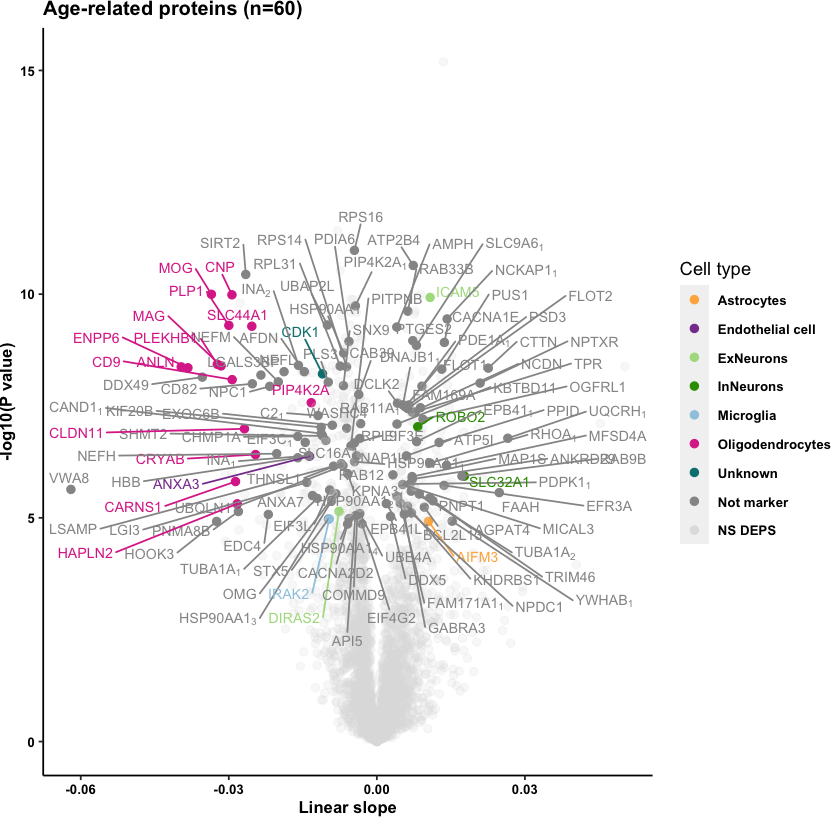

In [60]:
p_60

In [61]:
#jpeg("100_plus_plots/proteomics/volcano_plot_for_aging_related_protein_114_newCT.jpg",
#     width = 6, height = 8, units = 'in', res = 300)
p_114 <- plot_volcano_with_cell_enrich(Age_related_proteins_lm, 
                              setdiff(lm_index, pure_sig_age_index),
                              setdiff(lm_index, pure_sig_age_index), "Linear slope", "Age- and Braak-related proteins (n=114)")
#dev.off()

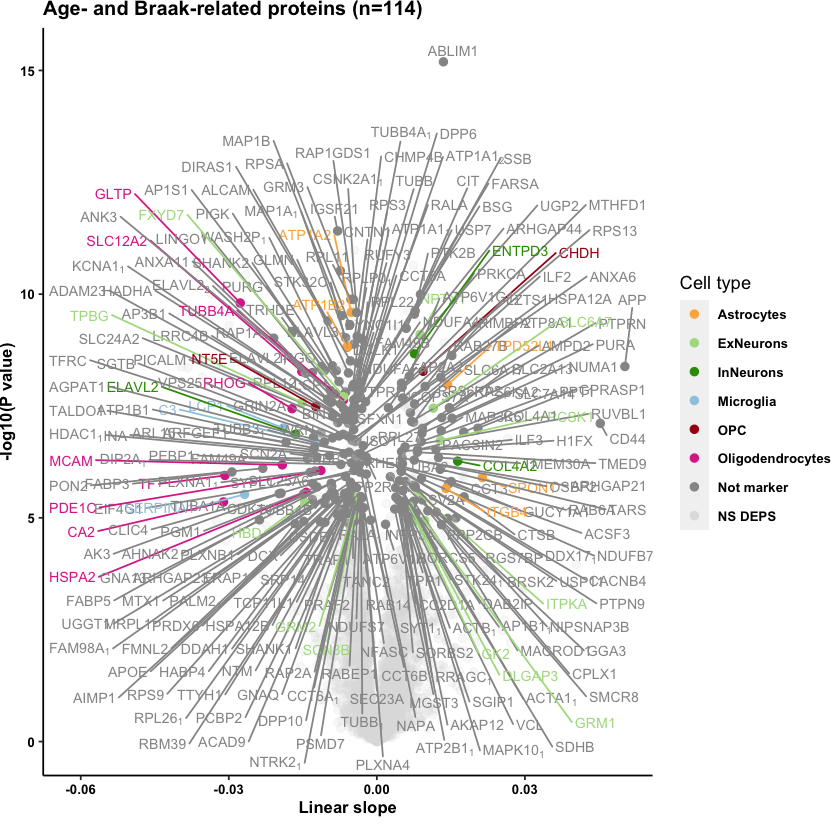

In [62]:
p_114

In [41]:
#legend <- plot_volcano_with_cell_enrich(Age_related_proteins_lm, 
#                              lm_index,
#                              lm_index, "Linear slope", "Age- and Braak-related proteins (n=174)")

In [42]:
Age_down_EWCE <- read.table("100_plus_results/Cell_type_deconvolution/EWCE_tempcort_AgeProt60_DOWN_BasedonDarm&Hodge.csv",
                            header =TRUE, stringsAsFactors=F, sep = ",")
Age_up_EWCE <- read.table("100_plus_results/Cell_type_deconvolution/EWCE_tempcort_AgeProt60_UP_BasedonDarm&Hodge.csv",
                            header =TRUE, stringsAsFactors=F, sep = ",")

Age_down_EWCE$CellType <- factor(Age_down_EWCE$CellType, levels = c("Astrocytes", "Endothelial", 
                                                                    "ExNeurons", "InNeurons", 
                                           "Microglia", "Oligodendrocytes", "OPC", "Unknown"))

Age_down_EWCE$star <- c("", "*")[as.numeric(Age_down_EWCE$p < 0.05) + 1]
Age_down_EWCE$label <- "Down-regulated protein"

Age_up_EWCE$CellType <- factor(Age_up_EWCE$CellType, levels = c("Astrocytes", "Endothelial", 
                                                                    "ExNeurons", "InNeurons", 
                                           "Microglia", "Oligodendrocytes", "OPC", "Unknown"))

Age_up_EWCE$star <- c("", "*")[as.numeric(Age_up_EWCE$p < 0.05) + 1]
Age_up_EWCE$label <- "Up-regulated protein"

Age_EWCE <- rbind(Age_down_EWCE, Age_up_EWCE)

In [43]:
plot_EWCE_celltype <- function(data, ymax){
    p <- ggplot(data=data, aes(x=CellType, y=sd_from_mean, fill = CellType, color = CellType)) +
        xlab("") + ylab("s.d. from the mean") + ylim(0, ymax) +
        geom_bar(stat="identity") +
        facet_wrap(~label,  ncol=1, strip.position = "right") +
        geom_text(aes(label=star), vjust=0.3, size=6, col = "black")+
        annotate("segment", x=-Inf, xend=8.5, y=-Inf, yend=-Inf, size = 1, linetype = "solid",
                                       colour = "black") +
        scale_color_manual(name="", breaks = c("Astrocytes", "Endothelial", "ExNeurons", "InNeurons", 
                                               "Microglia", "Oligodendrocytes", "OPC", "Unknown", 
                                               "NS_celltype", "NS_at_all"),
                               values = c(Astrocytes, Endothelial, ExNeurons, InNeurons, 
                                          Microglia, Oligodendrocytes, OPC, Unknown, 
                                          No_unique_enrichment, NS_DEPs)
                          ) +
        scale_fill_manual(name="", breaks = c("Astrocytes", "Endothelial", "ExNeurons", "InNeurons", 
                                              "Microglia", "Oligodendrocytes", "OPC", "Unknown", 
                                              "NS_celltype", "NS_at_all"),
                               values = c(Astrocytes, Endothelial, ExNeurons, InNeurons, 
                                          Microglia, Oligodendrocytes, OPC, Unknown, 
                                          No_unique_enrichment, NS_DEPs)
                          ) +
        theme(panel.border = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.background = element_blank(),
              legend.position = "none",
              legend.text = element_text(size = 5, color = "black", face = "bold"),
              axis.text.x = element_text(size = 8, color = "black", face = "bold", 
                                         vjust = 1, hjust = 1, angle=45),
              axis.title.y = element_text(size = 10, color = "black", face = "bold"),
              axis.text.y = element_text(size = 8, color = "black", face = "bold"),
              axis.line.y = element_line(size = 0.5, linetype = "solid",
                                       colour = "black"),
              strip.text.y = element_text(size = 8, color = "black", face = "bold", angle = 90),
              strip.background = element_rect(colour = "black")
              )
    #print(p)
    return(p)
}

In [44]:
#png("100_plus_plots/proteomics/EWCE_celltype_for_aging_protect_97.png", width=2000, height=1500, res=300)
#plot_EWCE_celltype(Age_EWCE, 2.5)
#dev.off()

In [45]:
pcell_60 <- plot_EWCE_celltype(Age_EWCE, 11.5)

Warning message:
“Removed 12 rows containing missing values (position_stack).”Warning message:
“Removed 12 rows containing missing values (geom_text).”

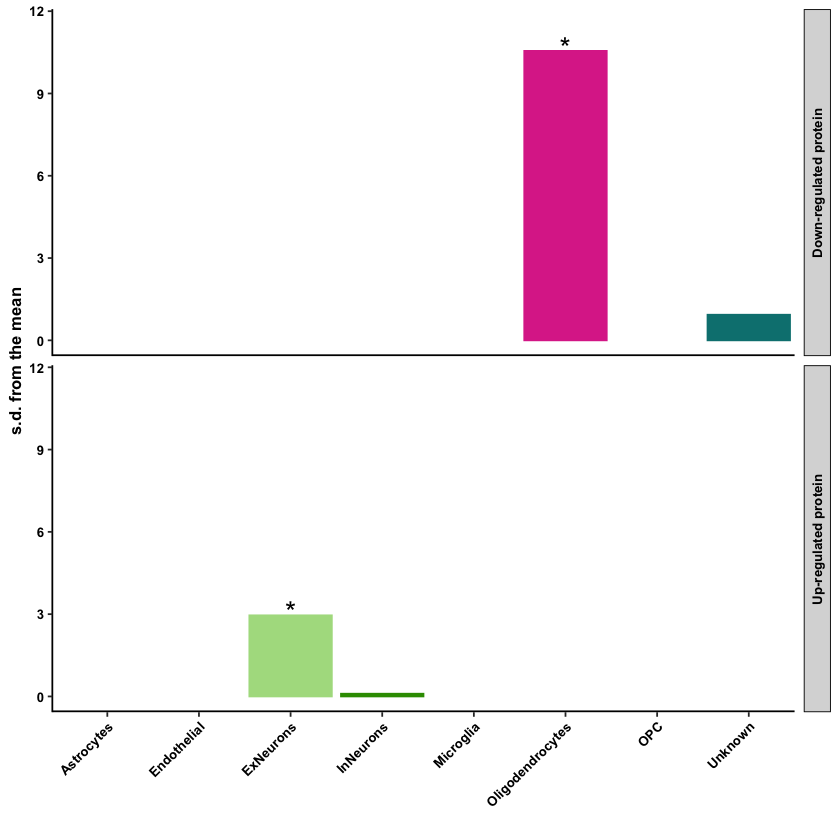

In [46]:
pcell_60

In [47]:
Age_down_EWCE <- read.table("100_plus_results/Cell_type_deconvolution/EWCE_tempcort_AgeProt114_DOWN_BasedonDarm&Hodge.csv",
                            header =TRUE, stringsAsFactors=F, sep = ",")
Age_up_EWCE <- read.table("100_plus_results/Cell_type_deconvolution/EWCE_tempcort_AgeProt114_UP_BasedonDarm&Hodge.csv",
                            header =TRUE, stringsAsFactors=F, sep = ",")

Age_down_EWCE$CellType <- factor(Age_down_EWCE$CellType, levels = c("Astrocytes", "Endothelial", 
                                                                    "ExNeurons", "InNeurons", 
                                           "Microglia", "Oligodendrocytes", "OPC", "Unknown"))

Age_down_EWCE$star <- c("", "*")[as.numeric(Age_down_EWCE$p < 0.05) + 1]
Age_down_EWCE$label <- "Down-regulated protein"

Age_up_EWCE$CellType <- factor(Age_up_EWCE$CellType, levels = c("Astrocytes", "Endothelial", 
                                                                    "ExNeurons", "InNeurons", 
                                           "Microglia", "Oligodendrocytes", "OPC", "Unknown"))

Age_up_EWCE$star <- c("", "*")[as.numeric(Age_up_EWCE$p < 0.05) + 1]
Age_up_EWCE$label <- "Up-regulated protein"

Age_EWCE <- rbind(Age_down_EWCE, Age_up_EWCE)

In [48]:
pcell_114 <- plot_EWCE_celltype(Age_EWCE, 2.5)

Warning message:
“Removed 11 rows containing missing values (position_stack).”Warning message:
“Removed 11 rows containing missing values (geom_text).”

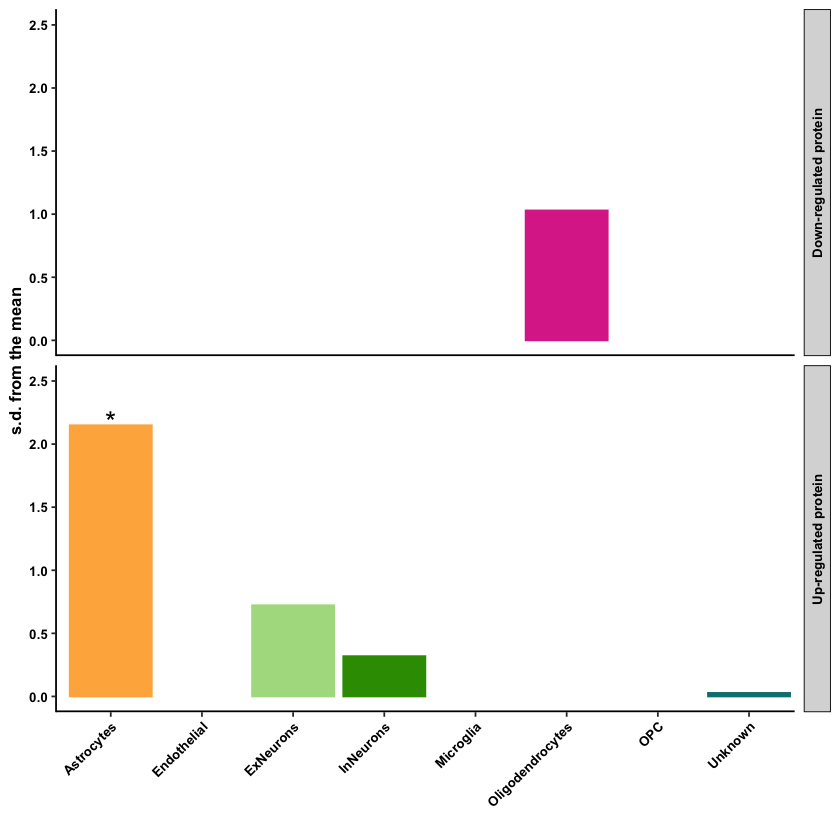

In [49]:
pcell_114

In [50]:
legend <- get_legend(legend)
p_60 <- p_60 + theme(legend.position='none')
p_114 <- p_114 + theme(legend.position='none')

In [63]:
p <- plot_grid(p_114, p_60, #pcell_114, pcell_60, 
               align = "v", axis = "lrtb", labels = letters[1:2], 
               label_size = 12, hjust = -1, vjust=1, rel_heights = c(0.58, 0.40),
               nrow = 1, ncol = 2)

In [65]:
save_plot("100_plus_plots/proteomics/Age-related_proteins_2to1_test.jpg", 
          p, base_height = 7, base_width = 11)

In [53]:
p_all <- plot_grid(p, legend,
               align = "h", axis = "lrtb", 
               rel_widths = c(0.85, 0.15),
               nrow = 1, ncol = 2)

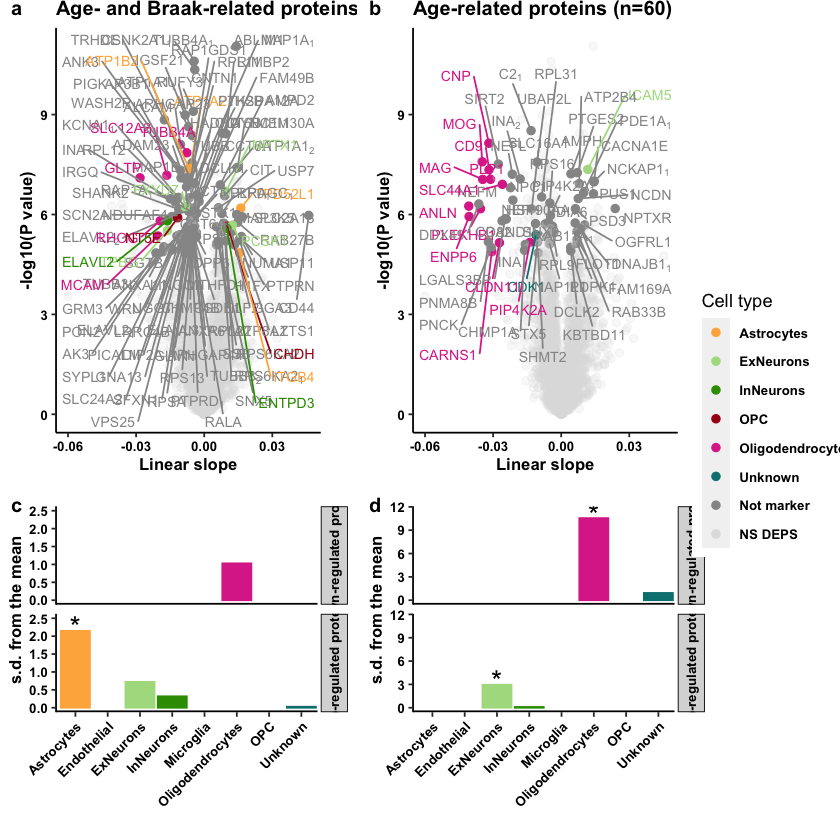

In [54]:
p_all

In [55]:
save_plot("100_plus_plots/proteomics/Age-related_proteins_4to1_names_sub.jpg", 
          p_all, base_height = 11, base_width = 11)

In [70]:
save(Age_related_proteins_lm, file="R_workstation/Centenarian_specific_protemoics_data_analysis_archive/For_ADPD/Age_related_proteins_lm.Rdata")

In [71]:
save(cell_type_matrix, file="R_workstation/Centenarian_specific_protemoics_data_analysis_archive/For_ADPD/cell_type_matrix.Rdata")

In [72]:
save(lm_index, file="R_workstation/Centenarian_specific_protemoics_data_analysis_archive/For_ADPD/lm_index.Rdata")

### Plot for ADPD

In [65]:
generate_data_matrix_for_plot <- function(data, sig_index){
    data$gene <- cell_type_matrix$protein
    data$celltype <- cell_type_matrix$celltype
    sig_DE_ns_celltype <- sig_index[which(is.na(cell_type_matrix[sig_index, ]$celltype))]
    data[sig_DE_ns_celltype,]$celltype <- "NS_celltype"
    data[-sig_index,]$celltype <- "NS_at_all"
    data[which(data$effect_size > 0), ]$celltype <- "NS_at_all"

    
    return(data)
}

In [66]:
plot_volcano_with_cell_enrich <- function(data, sig_index, label_index, xlab, title){
    data_matrix <- generate_data_matrix_for_plot(data, sig_index)
    
    #print(nrow(data_matrix))
    
    labels <- rep(NA, nrow(data_matrix))
    labels[label_index] <- data_matrix[label_index,]$gene
    
    #data_matrix$labels <- labels
    used_labels <- dict()
    
    multiple_names_idx <- grep(";", labels)
    for(i in multiple_names_idx){
        name <- unlist(str_split(labels[i], ";"))[1]
        if(name %in% used_labels$keys()){
            labels[i] <- paste(name, "[", used_labels[[name]]+1, "]", sep="")
            used_labels[[name]] <- used_labels[[name]] + 1
        }
        else{
            labels[i] <- paste(name, "[1]", sep="")
            used_labels[[name]] <- 1
        }
    }
    
    data_matrix$labels <- labels
    #print(data_matrix[multiple_names_idx, ])
    
    data_matrix$celltype <- factor(data_matrix$celltype, 
                                   levels=c("Neurons", 
                                            "Oligodendrocytes", 
                                            "NS_celltype", "NS_at_all"))
    
    data_matrix$alpha <- 0.2
    data_matrix[which((data_matrix$celltype %in% c("Neurons", "Oligodendrocytes")) & 
                      (data_matrix$effect_size < 0)), ]$alpha <- 1
    
    #print(table(data_matrix$celltype))
    
    #print(table(data_matrix$celltype))
    
    p <- ggplot(data=data_matrix, 
        aes(x=effect_size, y=-log10(p_value), col=celltype, label=labels)) +
        
        geom_point(size = 2, alpha = data_matrix$alpha) +
  
        geom_text_repel(size=3, show.legend = FALSE, parse=TRUE, na.rm=TRUE, seed = 123) +
        xlab(xlab) + ylab("-log10(P value)") + ggtitle(title) +
    
        scale_color_manual(name="Cell type", breaks = c("Neurons",
                                                        "Oligodendrocytes", 
                                                        "NS_celltype", "NS_at_all"),
                           values = c(InNeurons, Oligodendrocytes, NS_DEPs, NS_DEPs),
                           labels = c("Neurons",
                                      "Oligodendrocytes", 
                                      "Not marker", 
                                      "NS DEPS")
                      )+
    
    
        theme(panel.border = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(),
          
          legend.position = "right",
          legend.direction = "vertical",
          plot.title = element_text(face="bold", size = 12),
          plot.margin = ggplot2::margin(0, 0, 0.5, 0, "cm"),
          
          legend.text = element_text(size = 8, color = "black", face = "bold"),
          

              
            axis.text.x = element_text(size = 8, color = "black", face = "bold"),
              axis.title.x = element_text(size = 10, color = "black", face = "bold"),
              axis.title.y = element_text(size = 10, color = "black", face = "bold"),
              axis.text.y = element_text(size = 8, color = "black", face = "bold"),
              axis.line = element_line(size = 0.5, linetype = "solid",
                                       colour = "black"),
          #legend.position = "none")
              )
    return(p)
    
}

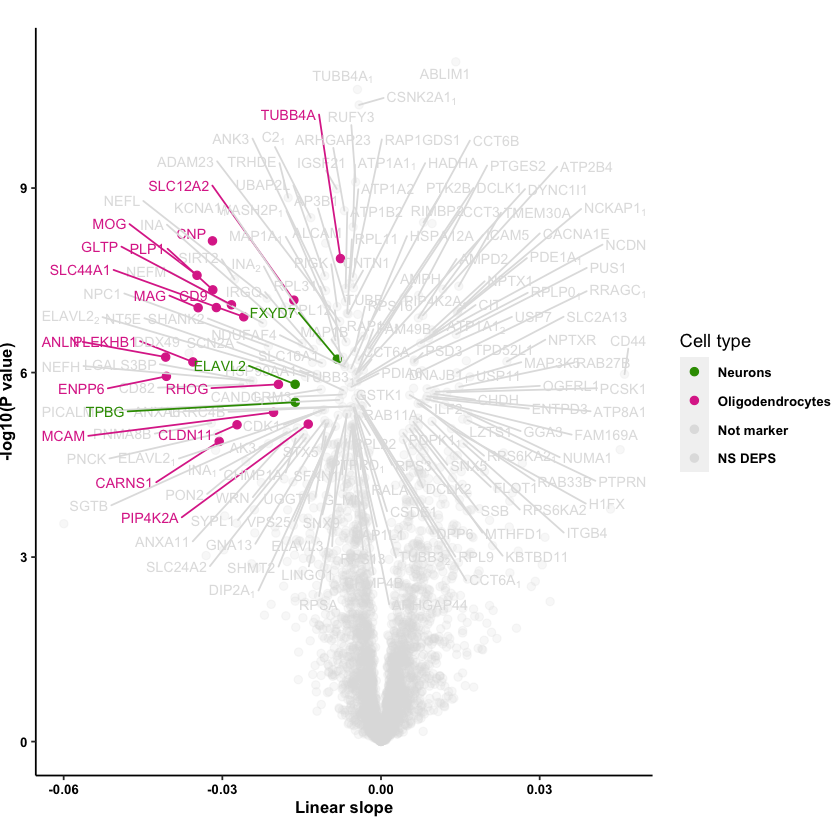

In [67]:
#jpeg("100_plus_plots/proteomics/volcano_plot_for_aging_related_protein_174_newCT.jpg",
#     width = 6, height = 8, units = 'in', res = 300)
legend <- plot_volcano_with_cell_enrich(Age_related_proteins_lm, 
                              lm_index,
                              lm_index, "Linear slope", " ")

legend
#dev.off()

In [165]:
Age_down_EWCE <- read.table("100_plus_results/Cell_type_deconvolution/EWCE_tempcort_AgeProtect38_DOWN_BasedonDarm&Hodge.csv",
                            header =TRUE, stringsAsFactors=F, sep = ",")
Age_up_EWCE <- read.table("100_plus_results/Cell_type_deconvolution/EWCE_tempcort_AgeProtect38_UP_BasedonDarm&Hodge.csv",
                            header =TRUE, stringsAsFactors=F, sep = ",")

Age_down_EWCE$CellType <- factor(Age_down_EWCE$CellType, levels = c("Astrocytes", "Endothelial", 
                                                                    "ExNeurons", "InNeurons", 
                                           "Microglia", "Oligodendrocytes", "OPC", "Unknown"))

Age_down_EWCE$star <- c("", "*")[as.numeric(Age_down_EWCE$p < 0.05) + 1]
Age_down_EWCE$label <- "Down-regulated protein"

Age_up_EWCE$CellType <- factor(Age_up_EWCE$CellType, levels = c("Astrocytes", "Endothelial", 
                                                                    "ExNeurons", "InNeurons", 
                                           "Microglia", "Oligodendrocytes", "OPC", "Unknown"))

Age_up_EWCE$star <- c("", "*")[as.numeric(Age_up_EWCE$p < 0.05) + 1]
Age_up_EWCE$label <- "Up-regulated protein"

Age_EWCE <- rbind(Age_down_EWCE, Age_up_EWCE)

plot_EWCE_celltype <- function(data, ymax){
    p <- ggplot(data=data, aes(x=CellType, y=sd_from_mean, fill = CellType, color = CellType)) +
        xlab("") + ylab("s.d. from the mean") + ylim(0, ymax) +
        geom_bar(stat="identity") +
        facet_wrap(~label,  ncol=1, strip.position = "right") +
        geom_text(aes(label=star), vjust=0.3, size=6, col = "black")+
        annotate("segment", x=-Inf, xend=8.5, y=-Inf, yend=-Inf, size = 1, linetype = "solid",
                                       colour = "black") +
        scale_color_manual(name="", breaks = c("Astrocytes", "Endothelial", "ExNeurons", "InNeurons", 
                                               "Microglia", "Oligodendrocytes", "OPC", "Unknown", 
                                               "NS_celltype", "NS_at_all"),
                               values = c(Astrocytes, Endothelial, ExNeurons, InNeurons, 
                                          Microglia, Oligodendrocytes, OPC, Unknown, 
                                          No_unique_enrichment, NS_DEPs)
                          ) +
        scale_fill_manual(name="", breaks = c("Astrocytes", "Endothelial", "ExNeurons", "InNeurons", 
                                              "Microglia", "Oligodendrocytes", "OPC", "Unknown", 
                                              "NS_celltype", "NS_at_all"),
                               values = c(Astrocytes, Endothelial, ExNeurons, InNeurons, 
                                          Microglia, Oligodendrocytes, OPC, Unknown, 
                                          No_unique_enrichment, NS_DEPs)
                          ) +
        theme(panel.border = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.background = element_blank(),
              legend.position = "none",
              legend.text = element_text(size = 5, color = "black", face = "bold"),
              axis.text.x = element_text(size = 8, color = "black", face = "bold", 
                                         vjust = 1, hjust = 1, angle=45),
              axis.title.y = element_text(size = 10, color = "black", face = "bold"),
              axis.text.y = element_text(size = 8, color = "black", face = "bold"),
              axis.line.y = element_line(size = 0.5, linetype = "solid",
                                       colour = "black"),
              strip.text.y = element_text(size = 8, color = "black", face = "bold", angle = 90),
              strip.background = element_rect(colour = "black")
              )
    #print(p)
    return(p)
}



In [167]:
png("100_plus_plots/proteomics/EWCE_celltype_for_aging_protect_38.png", width=2000, height=1500, res=300)
plot_EWCE_celltype(Age_EWCE, 12)
dev.off()

Warning message:
“Removed 11 rows containing missing values (position_stack).”Warning message:
“Removed 11 rows containing missing values (geom_text).”

pdf 
  2

In [50]:
test_abundance_for_aging_protective_proteins <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- cbind(metadata, intens)
    protein_metadata <- subset(protein_metadata, braak < 4)
    #print(head(protein_metadata))
    #print(table(protein_metadata$GROUP))
    
    fitLM <- lm(intens~age, subset(protein_metadata, GROUP == "ND"))
    
    predict_intens_LM <- predict(fitLM, subset(protein_metadata, GROUP == "CHC"))
    if(fitLM$coefficients[2] > 0){
        return(c(summary(fitLM)$coefficients[2,][4], 
                 summary(fitLM)$adj.r.squared,
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, GROUP == "CHC")$intens,
                      alternative = "greater")$p.value))
    }
    if(fitLM$coefficients[2] < 0){
        return(c(summary(fitLM)$coefficients[2,][4], 
                 summary(fitLM)$adj.r.squared, 
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, GROUP == "CHC")$intens,
                      alternative = "less")$p.value))
    }
}

In [51]:
aging_protective_test <- as.data.frame(t(sapply(lm_index, 
                                                test_abundance_for_aging_protective_proteins)))

aging_protective_test <- cbind(rownames(protein_intensity_combat)[lm_index],
                               aging_protective_test)

colnames(aging_protective_test) <- c("protein", 
                                     "F.p", "R_square", 
                                     "p_value")

aging_protective_test$adj.p_value_BH <- p.adjust(aging_protective_test$p_value, method = "BH")
aging_protective_test$adj.p_value_B <- p.adjust(aging_protective_test$p_value, method = "bonferroni")

In [52]:
length(which(aging_protective_test$adj.p_value_BH < 0.05))

[1] 201

In [53]:
aging_protective_test[which(aging_protective_test$adj.p_value_BH < 0.05), ]

protein                                  F.p          R_square    
2   CARNS1                                   0.0055191600  0.124578191
3   INPP5A                                   0.1967434227  0.013485370
5   MAP1B                                    0.0987713985  0.033952831
7   IRGQ                                     0.0006374232  0.190618359
9   AP1B1;AP2B1                              0.4649724490 -0.008885694
10  SV2A                                     0.1465038518  0.022079167
21  BIN1                                     0.1669778779  0.018229846
25  SHANK2                                   0.0156901079  0.091676639
26  HADHA                                    0.0485374849  0.055999182
27  PGM1                                     0.2388701844  0.008017912
29  RPS6KA2;RPS6KA3                          0.0033455204  0.140169398
31  TF                                       0.1082163845  0.031171719
32  CIT                                      0.0034836056  0.138915069
36  PALM2;PALM2-AKAP2                        0.0001174181  0.239845214
37  TPD52L1                                  0.0016591379  0.161751391
38  RALA                                     0.0042168814  0.132977672
39  NEFM                                     0.0177144679  0.087836385
42  PTGES2                                   0.0015361258  0.164101421
43  RRAGC;RRAGD                              0.0660815738  0.046352717
44  CNP                                      0.0020556574  0.155191884
45  TUBA1A;TUBA1B;TUBA1C;TUBA3C;TUBA4A;TUBA8 0.0345448468  0.066707959
47  PDPK1;PDPK2P                             0.0098450866  0.106399104
49  VWA8                                     0.0503113821  0.054872881
50  ITPKA                                    0.6028649058 -0.014157324
51  ANXA11                                   0.0057788990  0.123139156
52  COL4A2                                   0.0425052824  0.060170683
53  MGST3                                    0.3567670042 -0.002605869
56  CACNA1E                                  0.0917410610  0.036212604
57  AP1S1                                    0.0104599416  0.104488682
62  TPR                                      0.0313865985  0.069736272
⋮   ⋮                                        ⋮            ⋮           
326 TUBB;TUBB3;TUBB4A;TUBB4B                 0.0277149634 0.073669591 
327 GNAQ                                     0.0017795626 0.159610160 
328 RAP1A;RAP1B                              0.0037846377 0.136341600 
330 SPON1                                    0.0180690292 0.087209102 
331 MTX1                                     0.0430353797 0.059780634 
332 PNPT1                                    0.1646614762 0.018638331 
333 EFR3A                                    0.0279849210 0.073362999 
336 SLC6A7                                   0.0416960934 0.060775740 
337 STK24;STK26                              0.2256192210 0.009607945 
340 ACTB;ACTG1;POTEE                         0.3034583372 0.001548323 
342 AHNAK2                                   0.1020935158 0.032943568 
346 WASH2P;WASH3P;WASH4P;WASH6P;WASHC1       0.0334816783 0.067694981 
349 FABP3                                    0.1537031588 0.020661357 
352 CAND1;CAND2                              0.0034916286 0.138843698 
353 ITGB4                                    0.0127694041 0.098189786 
355 ANLN                                     0.0188053721 0.085944712 
356 BORCS5                                   0.0942618689 0.035381920 
358 RPL31                                    0.0373107853 0.064277538 
361 WRN                                      0.0233539679 0.079087090 
362 ROBO2                                    0.2401154286 0.007873869 
363 RGS7BP                                   0.2783836439 0.003839549 
364 NCKAP1;NCKAP1L                           0.0410297667 0.061283009 
369 PIGK                                     0.0067006789 0.118501156 
371 CCT6A;CCT6B                              0.0030094684 0.143447616 
372 CHMP4B                  

In [54]:
save_data$Cen_specific <- FALSE

In [55]:
save_data[which(aging_protective_test$adj.p_value_BH < 0.05), ]$Cen_specific <- TRUE

In [56]:
save_data

Protein                           
SLC12A2                            SLC12A2                           
CARNS1                             CARNS1                            
INPP5A                             INPP5A                            
FMNL2                              FMNL2                             
MAP1B                              MAP1B                             
SLC16A1                            SLC16A1                           
IRGQ                               IRGQ                              
NAPA                               NAPA                              
AP1B1;AP2B1                        AP1B1;AP2B1                       
SV2A                               SV2A                              
NFASC                              NFASC                             
MTHFD1                             MTHFD1                            
APOE                               APOE                              
HSPA12A                            HSPA12A                           
FLOT1                              FLOT1                             
C3                                 C3                                
KBTBD11                            KBTBD11                           
ATP1A2                             ATP1A2                            
PITPNB                             PITPNB                            
AMPH                               AMPH                              
BIN1                               BIN1                              
ATP1A1;ATP1A3                      ATP1A1;ATP1A3                     
RAB14                              RAB14                             
HSP90AA1;HSP90AB1;HSP90AB2P        HSP90AA1;HSP90AB1;HSP90AB2P       
SHANK2                             SHANK2                            
HADHA                              HADHA                             
PGM1                               PGM1                              
PACSIN2                            PACSIN2                           
RPS6KA2;RPS6KA3                    RPS6KA2;RPS6KA3                   
RPS14                              RPS14                             
⋮                                  ⋮                                 
RPL31                              RPL31                             
INA;NEFH;NEFL;NEFM                 INA;NEFH;NEFL;NEFM                
NPTXR                              NPTXR                             
WRN                                WRN                               
ROBO2                              ROBO2                             
RGS7BP                             RGS7BP                            
NCKAP1;NCKAP1L                     NCKAP1;NCKAP1L                    
RPL27                              RPL27                             
ARHGAP23                           ARHGAP23                          
YWHAB;YWHAG;YWHAH;YWHAZ            YWHAB;YWHAG;YWHAH;YWHAZ           
SLC7A14                            SLC7A14                           
PIGK                               PIGK                              
CLDN11                             CLDN11                            
CCT6A;CCT6B                        CCT6A;CCT6B                       
CHMP4B                             CHMP4B                            
NIPSNAP3B                          NIPSNAP3B                         
FXYD7                              FXYD7                             
DCX                                DCX                               
GRM1                               GRM1                              
UQCRH;UQCRHL                       UQCRH;UQCRHL                      
AGPAT1                             AGPAT1                            
SMCR8                              SMCR8                             
RAP2A                              RAP2A                             
SYPL1                              SYPL1                             
RPL11                              RPL11                             
DNAJB1;DNAJB4                      DNAJB1;DNA

In [57]:
save(file = "new_age_proteins_for_GOTERM.Rdata", save_data)

In [48]:
age_protect_idx <- lm_index[order(aging_protective_test$adj.p_value_BH)[1:length(which(aging_protective_test$adj.p_value_BH < 0.05))]]

In [49]:
length(age_protect_idx)

[1] 201

In [44]:
97 / 174

[1] 0.5574713

In [45]:
201 / 387

[1] 0.5193798

In [50]:
age_pure_idx <- setdiff(age_protect_idx, age_Braak_sig_idx)

In [51]:
age_Braak_idx <- setdiff(age_protect_idx, pure_sig_age_index)

In [52]:
length(age_pure_idx)
length(age_Braak_idx)

[1] 68

[1] 133

In [152]:
protein_intensity_combat[age_Braak_idx, ]

intensity_20190325_121_S16_020_CHC_011
PON2                                6.785258                             
TUBB                               13.659966                             
ABLIM1                              7.657241                             
MCAM                                6.605007                             
PTK2B                              10.679297                             
CSNK2A1;CSNK2A3                     9.777562                             
CCT6B                               9.704647                             
AK3                                 8.310239                             
ITGB4                               4.936122                             
TPD52L1                             7.327239                             
CIT                                10.051638                             
SNX5                                8.403881                             
SSB                                 7.355873                             
RAP1A;RAP1B                        10.378814                             
CCT6A                              11.647703                             
NDUFAF4                             7.837885                             
H1FX                                6.719061                             
RIMBP2                              7.223843                             
IGSF21                              9.660642                             
ANXA11                              7.908217                             
CCT6A;CCT6B                         8.696947                             
GLTP                                6.585857                             
TUBB4A                             13.439240                             
CNTN1                              14.433459                             
SCN2A                              10.339625                             
LZTS1                               6.013887                             
NUMA1                               7.654545                             
MAP1A;MAP1B                        12.163073                             
GGA3                                5.585617                             
ILF2                               10.073892                             
MAP3K5                              4.919333                             
RUFY3                              11.228627                             
CCT3                               12.040932                             
SYPL1                               7.759018                             
IRGQ                                8.734155                             
RALA                               10.475220                             
CHMP4B                              6.273761                             
WRN                                 8.718887                             
AMPD2                               9.301156                             
MAP1B                              13.818739                             
TUBB3;TUBB4A;TUBB4B                13.110905                             
RPS6KA2                             8.637624                             
RHOG                                6.084241                             
TUBB4A;TUBB4B;TUBB8                13.642885                             
RRAGC;RRAGD                         6.804478                             
USP11                               8.257355                             
WASH2P;WASH3P;WASH4P;WASH6P;WASHC1  5.690608                             
RPS13                              10.106452                             
RPS6KA2;RPS6KA3                     7.459233                             
PIGK                                5.572452                             
HADHA                              11.895305                             
DYNC1I1                             9.631309                             
PCSK1                               5.771025                             
SHANK2                              8.4

In [153]:
pure_aging_protective_protein <- cell_type_matrix[age_Braak_idx, ]

In [154]:
pure_aging_protective_protein$p.vale <- Age_related_proteins_lm[age_Braak_idx, ]$p_value
pure_aging_protective_protein$adj.lm.p <- Age_related_proteins_lm[age_Braak_idx, ]$adjusted_p_value
pure_aging_protective_protein$slope <- Age_related_proteins_lm[age_Braak_idx, ]$effect_size

In [155]:
pure_aging_protective_protein

protein                            genesymbol HUGO_gene celltype        
2340 PON2                               PON2       PON2      NA              
819  TUBB                               TUBB       TUBB      NA              
1903 ABLIM1                             ABLIM1     ABLIM1    NA              
1926 MCAM                               MCAM       MCAM      Oligodendrocytes
1575 PTK2B                              PTK2B      PTK2B     NA              
1950 CSNK2A1;CSNK2A3                    CSNK2A1    CSNK2A1   NA              
2694 CCT6B                              CCT6B      CCT6B     NA              
1198 AK3                                AK3        AK3       NA              
3164 ITGB4                              ITGB4      ITGB4     Astrocytes      
336  TPD52L1                            TPD52L1    TPD52L1   Astrocytes      
274  CIT                                CIT        CIT       NA              
2241 SNX5                               SNX5       SNX5      NA              
2762 SSB                                SSB        SSB       NA              
2955 RAP1A;RAP1B                        RAP1A      RAP1A     NA              
786  CCT6A                              CCT6A      CCT6A     NA              
1881 NDUFAF4                            NDUFAF4    NDUFAF4   NA              
828  H1FX                               H1FX       H1-10     NA              
2621 RIMBP2                             RIMBP2     RIMBP2    NA              
1993 IGSF21                             IGSF21     IGSF21    NA              
533  ANXA11                             ANXA11     ANXA11    NA              
3349 CCT6A;CCT6B                        CCT6A      CCT6A     NA              
2870 GLTP                               GLTP       GLTP      Oligodendrocytes
2012 TUBB4A                             TUBB4A     TUBB4A    Oligodendrocytes
1007 CNTN1                              CNTN1      CNTN1     NA              
673  SCN2A                              SCN2A      SCN2A     NA              
2155 LZTS1                              LZTS1      LZTS1     NA              
2179 NUMA1                              NUMA1      NUMA1     NA              
1130 MAP1A;MAP1B                        MAP1A      MAP1A     NA              
2165 GGA3                               GGA3       GGA3      NA              
2923 ILF2                               ILF2       ILF2      NA              
2538 MAP3K5                             MAP3K5     MAP3K5    NA              
2720 RUFY3                              RUFY3      RUFY3     NA              
671  CCT3                               CCT3       CCT3      NA              
3465 SYPL1                              SYPL1      SYPL1     NA              
62   IRGQ                               IRGQ       IRGQ      NA              
357  RALA                               RALA       RALA      NA              
3362 CHMP4B                             CHMP4B     CHMP4B    NA              
3281 WRN                                WRN        WRN       NA              
1243 AMPD2                              AMPD2      AMPD2     NA              
35   MAP1B                              MAP1B      MAP1B     NA              
816  TUBB3;TUBB4A;TUBB4B                TUBB3      TUBB3     NA              
1961 RPS6KA2                            RPS6KA2    RPS6KA2   NA              
2268 RHOG                               RHOG       RHOG      Oligodendrocytes
1147 TUBB4A;TUBB4B;TUBB8                TUBB4A     TUBB4A    Oligodendrocytes
414  RRAGC;RRAGD                        RRAGC      RRAGC     NA              
1987 USP11                              USP11      USP11     NA              
3091 WASH2P;WASH3P;WASH4P;WASH6P;WASHC1 WASH2P     WASH2P    NA              
2708 RPS13                              RPS13      RPS13     NA              
256  RPS6KA2;RPS6KA3                    RPS6KA2    RPS6KA2   NA              
3342 PIGK                               PIGK       PIGK      NA              
250  HADHA                 

In [134]:
aging_protective_protein$regulation <- sapply(aging_protective_protein$effect_size, function(x){
    if(x < 0)
        return("Down")
    else
        return("Up")
})

In [135]:
write.table(pure_aging_protective_protein, 
            "100_plus_results/Age_related_protein/Age_protein_CEN_specific_clean.tsv", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [57]:
write.table(aging_protective_protein[aging_protective_protein$regulation == "Down", ], 
            "100_plus_results/Age_related_protein/Age_protein_CEN_specific_clean_Down.tsv", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [156]:
write.table(pure_aging_protective_protein, 
            "100_plus_results/Age_related_protein/Age_protein_CEN_specific_clean_59.tsv", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [41]:
plot_protective_proteins_aging <- function(index){
    temp_prot <- data.frame(age = as.numeric(metadata$age),
                            group = as.character(metadata$GROUP),
                            intensity = as.numeric(protein_intensity_combat[index,]))
    
    #print(length(which((temp_prot$age >= 80)&(temp_prot$intensity < 6.5)&(temp_prot$group == "ND"))))
    temp_prot <- subset(temp_prot, group != "AD")
    temp_prot$group <- factor(temp_prot$group, levels=c("ND", "AD", "CHC"))
    
    CHC_mean <- mean(temp_prot[which(temp_prot$group == "CHC"), ]$intensity)
    
    x1 <- min(temp_prot[which(temp_prot$group == "CHC"), ]$age)
    y1 <- CHC_mean
    x2 <- max(temp_prot[which(temp_prot$group == "CHC"), ]$age)
    y2 <- CHC_mean
    
    y_start <- round(min(temp_prot$intensity)) - 0.1
    y_end <- round(max(temp_prot$intensity)) + 0.1
    
    #y_start <- 6
    #y_end <- 16
    
    #if(y_start == y_end)
    #    y_end = y_end + 1
    
    p <- ggplot(subset(temp_prot, group == "ND"), aes(x = age, y = intensity, col = group))+
        geom_point() +
        geom_smooth(method = "lm", formula = y ~ x, fullrange=TRUE, level = 0.9) +
        #geom_point(data = subset(temp_prot, group != "ND"), mapping = aes(x = age, y = intensity, col = group)) +
        xlab("Age [y]") +
        ylab("log2(protein intensity)") +
        ggtitle(rownames(protein_intensity_combat)[index]) +
    
        geom_segment(aes(x = x1, y = y1, xend = x2, yend = y2), 
                     color = color_CHC, size = 1,
                     data = temp_prot) + 
    
        scale_y_continuous(breaks=seq(y_start, y_end, 0.2)) +
    
        scale_color_manual(name="Group", breaks = c("ND", "AD", "CHC"), 
                           values = c(color_ND, color_AD, color_CHC),
                           labels = c(paste("Non-dementia (n=", 
                                            length(which(temp_prot$group == "ND")), ")", sep = ''),
                                      paste("Alzheimer's (n=", 
                                            length(which(temp_prot$group == "AD")), ")", sep = ''),
                                      paste("Centenarian (n=", 
                                            length(which(temp_prot$group == "CHC")), ")", sep = '')),
                           guide = guide_legend(override.aes = list(alpha = 1, linetype = c("solid", "solid")))
                          )+
    
        theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
          #legend.position = "bottom",
          legend.position = "bottom",
          panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Vertical major grid lines
          panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Horizontal major grid lines
          panel.grid.minor.x = element_line(), # Vertical minor grid lines
          panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.title = element_text(hjust = 0),
          axis.title.x = element_text(color = "black", size = 12),
          axis.title.y = element_text(color = "black", size = 12),
          
          axis.text.x = element_text(size = 12, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = 12, color = "black"),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
         )
    return(p)
    
}

In [38]:
PON2_plot <- plot_protective_proteins_aging(age_protect_idx[1])
PON2_plot

ERROR: Error in data.frame(age = as.numeric(metadata$age), group = as.character(metadata$GROUP), : object 'age_protect_idx' not found


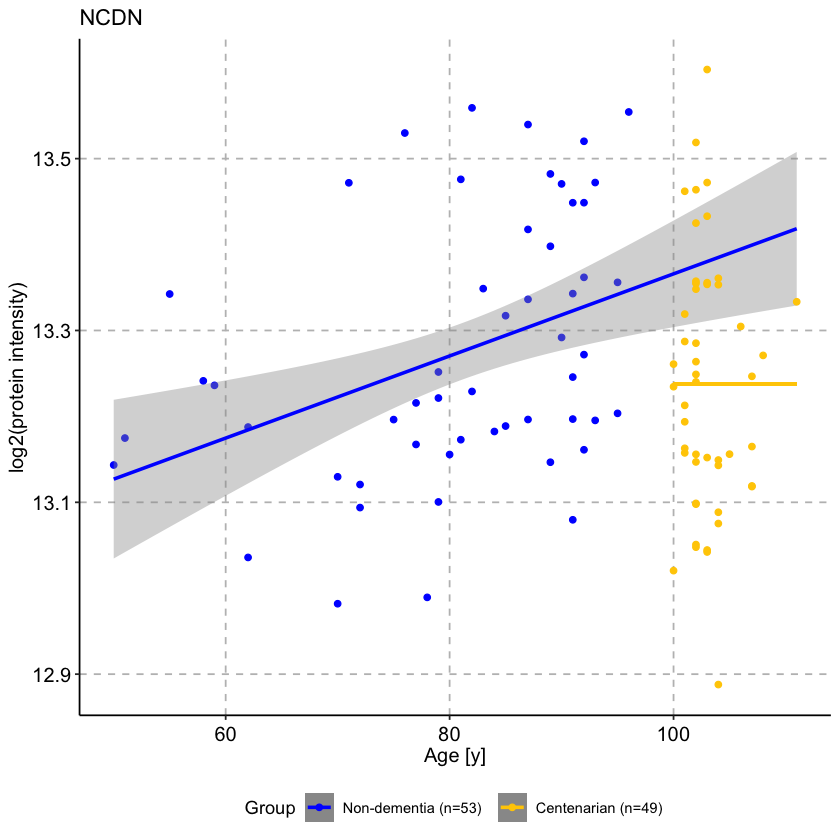

In [282]:
NCDN_plot <- plot_protective_proteins_aging(age_protect_idx[3])
NCDN_plot

In [301]:
p <- plot_grid(PON2_plot, NCDN_plot, 
               align = "v", axis = "lrtb", labels = c("A", "B"), 
               label_size = 12, hjust = -1, vjust=1.7, rel_heights = c(0.48, 0.52),
               nrow = 2, ncol = 1)

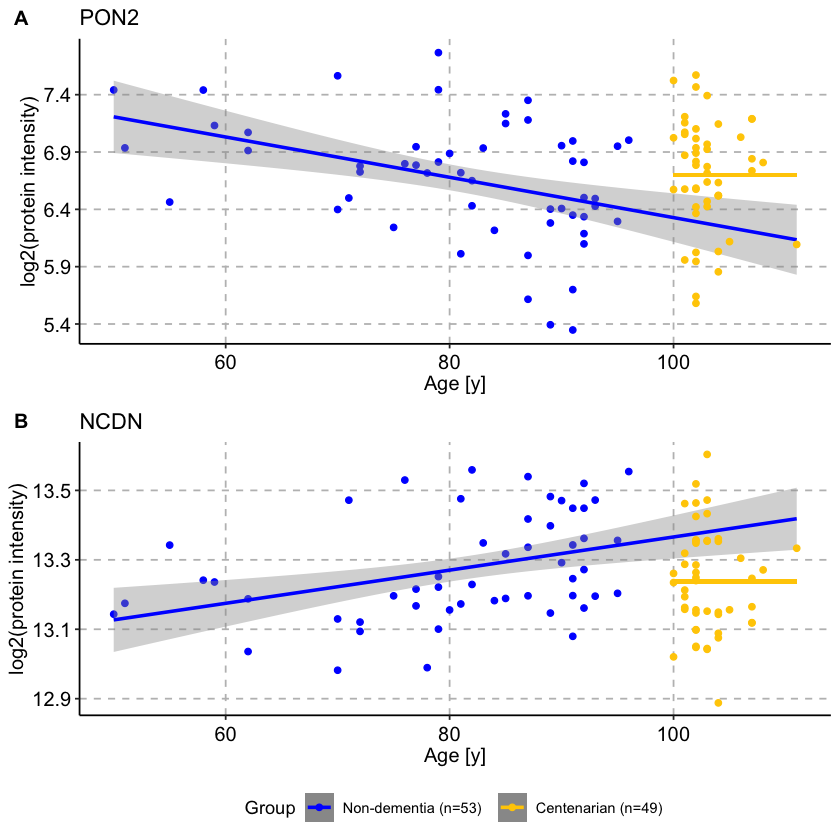

In [302]:
p

In [303]:
save_plot("100_plus_plots/proteomics/Cen specific proteins 2sample.jpg", 
          p, base_height = 8, base_width = 6)

In [163]:
cal_corr_per_protein <- function(p_index, variable, sample_idx, method = "pearson"){
    x_var = as.numeric(protein_intensity_combat[p_index, ][sample_idx])
    y_var = as.numeric(metadata[, variable][sample_idx])
    return(c(cor.test(x = x_var, y = y_var, method = method, exact = FALSE)$p.value,
             cor.test(x = x_var, y = y_var, method = method, exact = FALSE)$estimate))
    
}

In [164]:
Braak_corr_for_aging_protein <- as.data.frame(t(sapply(pure_sig_age_index, cal_corr_per_protein, "fBraak", Braak_test_index)))
Abeta_corr_for_aging_protein <- as.data.frame(t(sapply(pure_sig_age_index, cal_corr_per_protein, "Abeta", Braak_test_index)))
Age_corr_for_aging_protein <- as.data.frame(t(sapply(pure_sig_age_index, cal_corr_per_protein, "age", Braak_test_index)))

In [176]:
Braak_corr_for_aging_protein$variable <- "Braak"
Abeta_corr_for_aging_protein$variable <- "Abeta"
Age_corr_for_aging_protein$variable <- "Age"

In [177]:
corr_for_aging_protein <- rbind(Braak_corr_for_aging_protein, 
                                Abeta_corr_for_aging_protein, Age_corr_for_aging_protein)

In [178]:
colnames(corr_for_aging_protein) <- c("p_value", "corr", "variable")

In [179]:
corr_for_aging_protein$variable <- factor(corr_for_aging_protein$variable, levels = c("Age", "Braak", "Abeta"))

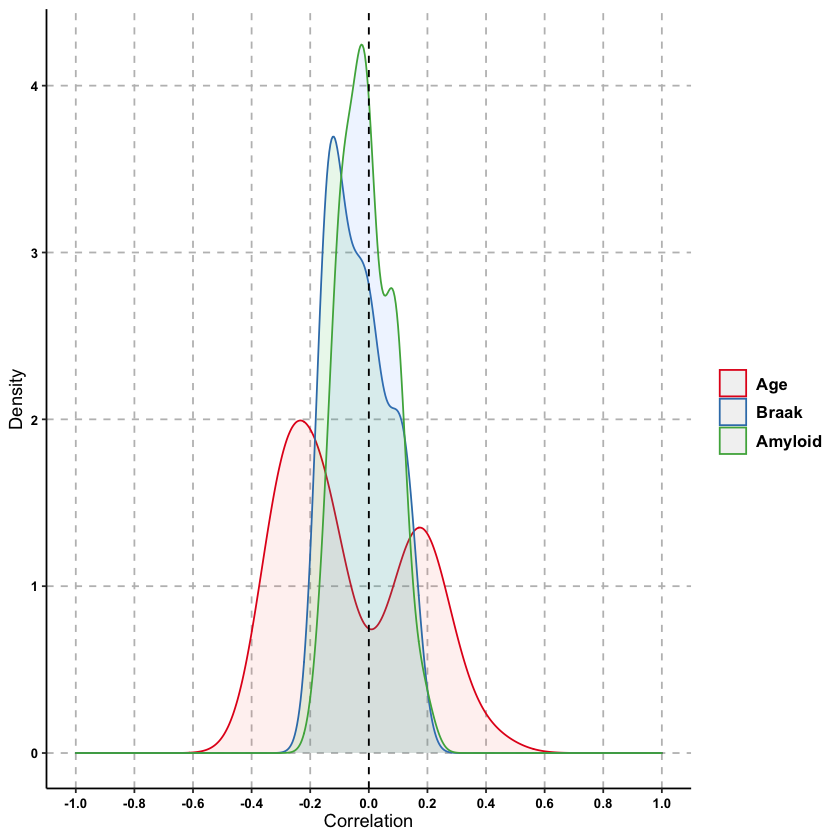

In [185]:
ggplot(corr_for_aging_protein, 
       aes(x = corr, col = variable, fill = variable)) +
    geom_density(alpha=0.1, position = "identity") +
    xlab("Correlation") + ylab("Density") +
    
    scale_x_continuous(limits = c(-1, 1), breaks=seq(-1, 1, 0.2)) +
    #scale_y_continuous(limits = c(0, 2), breaks=seq(0, 2, 0.5)) +

    geom_vline(xintercept = 0, linetype="dashed") +
        
    scale_color_manual(name="", values = c('#E41A1C', '#377EB8', '#4DAF4A'), 
                       breaks = c("Age", "Braak", "Abeta"),
                       labels = c("Age", "Braak", "Amyloid")) +
    
    guides(fill = FALSE) +

    theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Vertical major grid lines
          panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Horizontal major grid lines
          panel.grid.minor.x = element_line(), # Vertical minor grid lines
          panel.grid.minor.y = element_line(),  # Vertical major grid lines
          
          legend.position = "right",
          legend.direction = "vertical",
          
          legend.text = element_text(size = 10, color = "black", face = "bold"),
          
          axis.text.x = element_text(size = 8, color = "black", face = "bold", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = 8, color = "black", face = "bold"),
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black"))

In [36]:
calc_protein_mean_in_group <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- as.data.frame(cbind(metadata, intens))
    
    return(c(rownames(protein_intensity_combat)[index], 
             mean(subset(protein_metadata, (GROUP == "ND") & (age >= 80))$intens), 
             mean(subset(protein_metadata, GROUP == "CHC")$intens)))
}

In [37]:
protein_mean <- as.data.frame(t(sapply(lm_index, calc_protein_mean_in_group)), 
                              stringsAsFactors = FALSE)
colnames(protein_mean) <- c("protein", "ND_80", "CHC")

In [38]:
protein_mean[protein_mean$protein == "TOMM34",]

protein ND_80            CHC             
133 TOMM34  7.58795473432099 7.33916315769738

In [99]:
plot_intenbox <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- as.data.frame(cbind(metadata, intens))
    
    #print(length(which((protein_metadata$age >= 80)&(protein_metadata$intens < 6.5)&(protein_metadata$GROUP == "ND"))))
    
    plot_matrix <- subset(protein_metadata, GROUP %in% c("ND", "CHC"))
    
    plot_matrix$age_level <- NA
    plot_matrix[which((plot_matrix$GROUP == "ND") & (plot_matrix$age < 80)), ]$age_level <- 1
    plot_matrix[which((plot_matrix$GROUP == "ND") & (plot_matrix$age >= 80)), ]$age_level <- 2
    plot_matrix[which((plot_matrix$GROUP == "CHC") & (plot_matrix$age >= 100)), ]$age_level <- 3
    
    #print(table(plot_matrix$age_level))
    
    plot_matrix$age_level <- as.factor(plot_matrix$age_level)
    
    my_comparisons <- list( c("1", "2"), c("2", "3"), c("1", "3") )
    
    p <- ggplot(plot_matrix, aes(x = age_level, y = intens, fill = age_level))+
        geom_boxplot(color = "black") +
        geom_jitter(shape=15, position=position_jitter(0.2)) +
        xlab("Age") +
        ylab("log2(protein intensity)") +
        ggtitle(rownames(protein_intensity_combat)[index]) +
        scale_x_discrete(breaks=c(1, 2, 3), labels = c("<80", "80-100", ">=100")) +
    
        scale_fill_manual(name="Age group", breaks = c(1, 2, 3), 
                          values = c(color_ND, color_AD, color_CHC), 
                          labels = c("ND, age<80", 
                                     "ND, 80<=age<100",
                                     "CHC, age>=100"))+
    
        stat_compare_means(method = "t.test", comparisons = my_comparisons)+
    
        theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
            legend.position="bottom",
    
          panel.grid.major.x = element_line(), # Vertical major grid lines
          panel.grid.major.y = element_line(), # Horizontal major grid lines
          panel.grid.minor.x = element_line(), # Vertical minor grid lines
          panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.title = element_text(hjust = 0.5),
          axis.title.x = element_text(color = "black", size = 12),
          axis.title.y = element_text(color = "black", size = 12),
          
          axis.text.x = element_text(size = 12, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = 12, color = "black"),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
         )
    return(p)
}

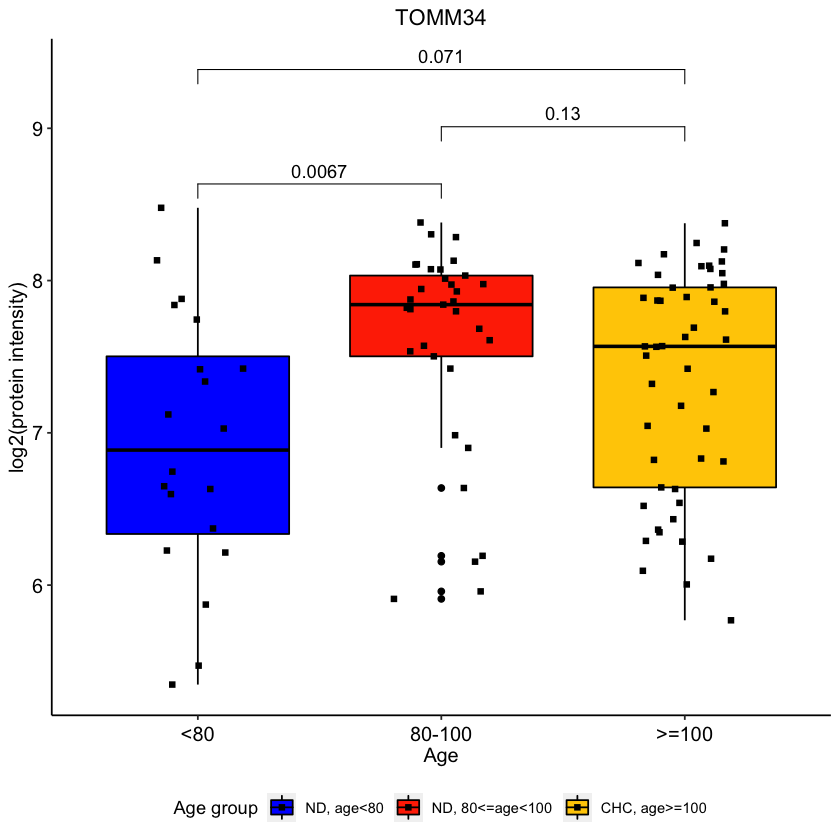

In [100]:
plot_intenbox(lm_index[which(rownames(protein_intensity_combat)[lm_index] == "TOMM34")])

In [153]:
aging_protective_plots <- NULL

for(i in 1:length(plot_top_9_index)){
p  <- plot_intenbox(plot_top_9_index[i])
    aging_protective_plots[[i]] <- p
}

In [156]:
p <- plot_grid(plotlist = aging_protective_plots, ncol = 3, nrow = 5)
save_plot("100_plus_plots/proteomics/Aging_protective_protein_boxplot_13.pdf", p, base_height = 20, base_width = 12)

In [509]:
which(rownames(protein_intensity_combat)[lm_index] == "TOMM34")

[1] 133

In [42]:
test_abundance_for_aging_protective_proteins <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- cbind(metadata, intens)
    
    return(t.test(x = subset(protein_metadata, (GROUP == "ND") & (age >= 80))$intens, 
                  y = subset(protein_metadata, GROUP == "CHC")$intens)$p.value)
}

In [43]:
aging_diff_test <- as.numeric(lapply(pure_sig_age_index, 
                                     test_abundance_for_aging_protective_proteins))

aging_diff_test <- data.frame(protein = rownames(protein_intensity_combat)[pure_sig_age_index],
                              p_value = aging_diff_test)

aging_diff_test$adj.p_value <- p.adjust(aging_diff_test$p_value, method = "BH")

In [44]:
diff_80_index <- pure_sig_age_index[which(aging_diff_test$p_value < 0.05)]

In [45]:
length(diff_80_index)

[1] 7

In [46]:
aging_diff_test[which(aging_diff_test$p_value < 0.05), ]

protein        p_value     adj.p_value
5  AMPH           0.018140917 0.3088998  
10 CACNA1E        0.001879216 0.1183906  
11 NCDN           0.007630032 0.2403460  
20 STX5           0.040302186 0.3627197  
38 PNCK           0.029419031 0.3088998  
55 CAND1;CAND2    0.023493778 0.3088998  
60 NCKAP1;NCKAP1L 0.025788398 0.3088998

In [98]:
test_abundance_for_aging_protective_proteins <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- cbind(metadata, intens)
    
    return(t.test(x = subset(protein_metadata, GROUP == "ND")$intens, 
                  y = subset(protein_metadata, GROUP == "CHC")$intens)$p.value)
}

In [99]:
test_abundance_for_aging_protective_proteins <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- cbind(metadata, intens)
    
    return(t.test(x = subset(protein_metadata, (GROUP == "ND") & (age >= 80))$intens, 
                  y = subset(protein_metadata, GROUP == "CHC")$intens)$p.value)
}

In [199]:
aging_diff_test <- as.numeric(lapply(1:nrow(protein_intensity_combat), 
                                     test_abundance_for_aging_protective_proteins))

aging_diff_test <- data.frame(protein = rownames(protein_intensity_combat),
                              p_value = aging_diff_test)

aging_diff_test$adj.p_value <- p.adjust(aging_diff_test$p_value, method = "BH")

In [200]:
aging_diff_index <- which(aging_diff_test$adj.p_value < 0.05)

In [201]:
dim(protein_intensity_combat[aging_diff_index,])

[1] 133 190

In [332]:
aging_diff_plots <- NULL

for(i in 1:9){
p  <- plot_protective_proteins_aging(aging_diff_index[i])
aging_diff_plots[[i]] <- p
}

p <- plot_grid(plotlist = aging_diff_plots, ncol = 3, nrow = 3)
save_plot("Aging_diff_protein_plot_80.pdf", p, base_height = 10, base_width = 15)

In [206]:
aging_diff_test <- as.numeric(lapply(pure_sig_age_index, 
                                     test_abundance_for_aging_protective_proteins))

aging_diff_test <- data.frame(protein = rownames(protein_intensity_combat[pure_sig_age_index,]),
                              p_value = aging_diff_test)

aging_diff_test$adj.p_value <- p.adjust(aging_diff_test$p_value, method = "BH")

In [207]:
aging_diff_index <- pure_sig_age_index[which(aging_diff_test$adj.p_value < 0.05)]

In [208]:
length(aging_diff_index)

[1] 0

In [340]:
aging_diff_plots <- NULL

for(i in 1:7){
p  <- plot_protective_proteins_aging(aging_diff_index[i])
aging_diff_plots[[i]] <- p
}

p <- plot_grid(plotlist = aging_diff_plots, ncol = 3, nrow = 3)
save_plot("Aging_diff_protein_plot_in_aging_related_protein.pdf", p, base_height = 10, base_width = 15)

In [39]:
test_abundance_for_aging_protective_proteins <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- cbind(metadata, intens)
    
    fitLM <- lm(intens~age, subset(protein_metadata, GROUP == "ND"))
    
    #print(summary(fitLM))
    predict_intens_LM <- predict(fitLM, subset(protein_metadata, GROUP == "CHC"))
        if(fitLM$coefficients[2] > 0){
        return(c(summary(fitLM)$coefficients[2,][4], 
                 summary(fitLM)$adj.r.squared,
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, GROUP == "CHC")$intens,
                      alternative = "greater")$p.value))
    }
    if(fitLM$coefficients[2] < 0){
        return(c(summary(fitLM)$coefficients[2,][4], 
                 summary(fitLM)$adj.r.squared, 
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, GROUP == "CHC")$intens,
                      alternative = "less")$p.value))
    }
}

In [35]:
test_abundance_for_aging_protective_proteins <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- cbind(metadata, intens)
    protein_metadata <- subset(protein_metadata, braak < 4)
    
    fitLM <- lm(intens~age, subset(protein_metadata, GROUP == "ND"))
    
    #print(summary(fitLM))
    predict_intens_LM <- predict(fitLM, subset(protein_metadata, GROUP == "CHC"))
        if(fitLM$coefficients[2] > 0){
        return(c(summary(fitLM)$coefficients[2,][4], 
                 summary(fitLM)$adj.r.squared,
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, GROUP == "CHC")$intens,
                      alternative = "greater")$p.value))
    }
    if(fitLM$coefficients[2] < 0){
        return(c(summary(fitLM)$coefficients[2,][4], 
                 summary(fitLM)$adj.r.squared, 
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, GROUP == "CHC")$intens,
                      alternative = "less")$p.value))
    }
}

In [60]:
#aging_protective_test_rlm <- aging_protective_test

In [40]:
test_abundance_for_aging_protective_proteins(1)

Pr(>|t|)                         
0.001410286 0.166703791 0.053448079

In [44]:
aging_protective_test <- as.data.frame(t(sapply(lm_index, test_abundance_for_aging_protective_proteins)))

aging_protective_test <- cbind(rownames(protein_intensity_combat)[lm_index],
                               aging_protective_test)

colnames(aging_protective_test) <- c("protein", 
                                     "F.p", "R_square", 
                                     "p_value")

aging_protective_test$adj.p_value_BH <- p.adjust(aging_protective_test$p_value, method = "BH")
aging_protective_test$adj.p_value_B <- p.adjust(aging_protective_test$p_value, method = "bonferroni")

In [47]:
length(which((aging_protective_test$adj.p_value_BH < 0.05)))
aging_protective_idx_43 <- lm_index[which(aging_protective_test$adj.p_value_BH < 0.05)]

[1] 110

In [73]:
length(which((aging_protective_test$adj.p_value_BH < 0.05)))
aging_protective_idx_41 <- pure_sig_age_index[which(aging_protective_test$adj.p_value_BH < 0.05)]

[1] 41

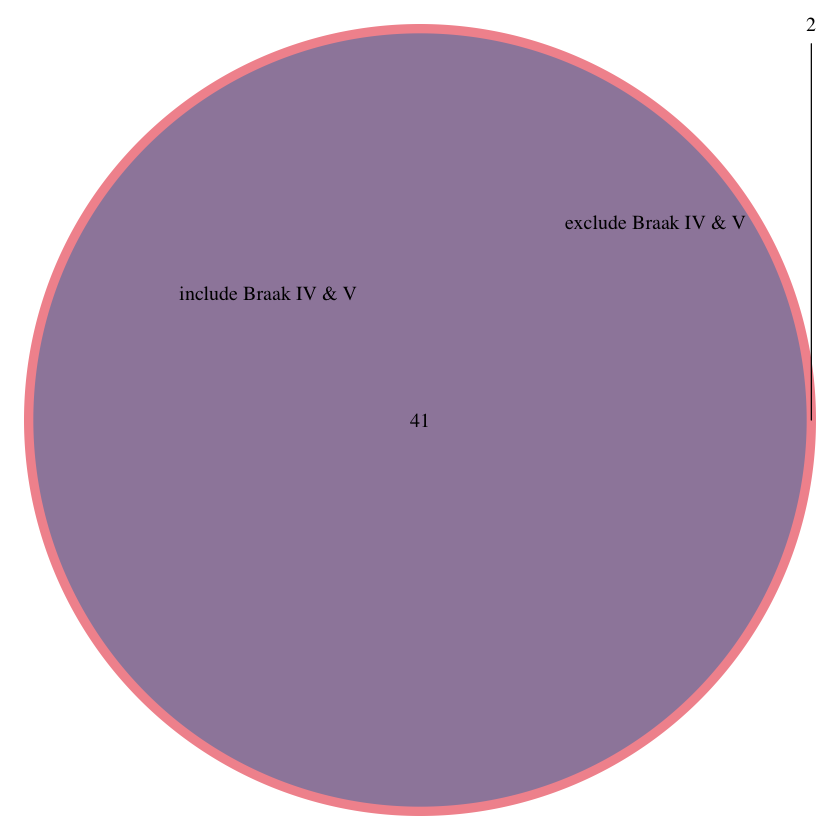

In [74]:
x <- list(set_1 = aging_protective_idx_43, 
          set_2 = aging_protective_idx_41)

p <- venn.diagram(x, filename = NULL, imagetype = "png", fill=c('#E41A1C', '#377EB8'),
                  category.names=c("include Braak IV & V","exclude Braak IV & V"), lwd = 0, alpha = 0.5, cat.dist=c(-0.1, -0.04),
                  height=600,width=600,res=150)
grid.draw(p)

In [111]:
special_63_idx_2 <- setdiff(aging_protective_idx_43, aging_protective_idx_41)
special_63_idx_2

[1] 1537 2375

In [48]:
for(i in aging_protective_idx_43){
    cat(rownames(protein_intensity_combat)[i], end = "\n")
}

CARNS1 
MAP1B 
IRGQ 
SHANK2 
HADHA 
RPS6KA2;RPS6KA3 
CIT 
RPS3 
TPD52L1 
RALA 
NEFM 
PTGES2 
RRAGC;RRAGD 
CNP 
GSTK1 
PDPK1;PDPK2P 
ANXA11 
CACNA1E 
RPSA 
DYNC1I1 
CCT3 
SCN2A 
INA 
ALCAM 
NCDN 
CCT6A 
SNX9 
TUBB3;TUBB4A;TUBB4B 
TUBB 
MOG 
H1FX 
NEFL 
PNMA8B 
RAB11A;RAB11B 
CNTN1 
CSDE1 
STX5 
MAP1A;MAP1B 
TUBB4A;TUBB4B;TUBB8 
AK3 
AMPD2 
SIRT2 
SLC44A1 
CD9 
PLEKHB1 
C2;CFB 
RPS16 
TRAPPC10 
PTK2B 
LRRC4B 
MRPS22 
USP7 
GNA13 
MAG 
PIP4K2A;PIP4K2B 
PDIA6 
TPBG 
DIAPH1 
NDUFAF4 
PDE1A;PDE1C 
ABLIM1 
MCAM 
PNCK 
CSNK2A1;CSNK2A3 
AP3B1 
RPS6KA2 
USP11 
IGSF21 
TUBB4A 
PSD3 
CDK1 
LZTS1 
GGA3 
NUMA1 
LGALS3BP 
OGFRL1 
SNX5 
RHOG 
TUBB3;TUBB6 
INA;NEFH;NEFL;NEFM;VIM 
PCSK1 
TOMM34 
MAP3K5 
ENPP6 
RIMBP2 
UBAP2L 
CCT6B 
FAM169A 
NAP1L1 
RPS13 
RUFY3 
SSB 
DIP2A;DIP2C 
GLTP 
ILF2 
RAP1A;RAP1B 
WASH2P;WASH3P;WASH4P;WASH6P;WASHC1 
CAND1;CAND2 
ITGB4 
ANLN 
RPL31 
WRN 
NCKAP1;NCKAP1L 
ARHGAP23 
PIGK 
CCT6A;CCT6B 
CHMP4B 
SYPL1 
DNAJB1;DNAJB4 
CHMP1A 


In [88]:
aging_protective_test <- as.data.frame(t(sapply(lm_index, test_abundance_for_aging_protective_proteins)))

aging_protective_test <- cbind(rownames(protein_intensity_combat)[lm_index],
                               aging_protective_test)

colnames(aging_protective_test) <- c("protein", 
                                     "F.p", "R_square", 
                                     "p_value")

aging_protective_test$adj.p_value_BH <- p.adjust(aging_protective_test$p_value, method = "BH")
aging_protective_test$adj.p_value_B <- p.adjust(aging_protective_test$p_value, method = "bonferroni")

In [89]:
length(which((aging_protective_test$adj.p_value_BH < 0.05)))
aging_protective_idx_110 <- lm_index[which(aging_protective_test$adj.p_value_BH < 0.05)]

[1] 110

In [86]:
length(which((aging_protective_test$adj.p_value_BH < 0.05)))
aging_protective_idx_100 <- lm_index[which(aging_protective_test$adj.p_value_BH < 0.05)]

[1] 100

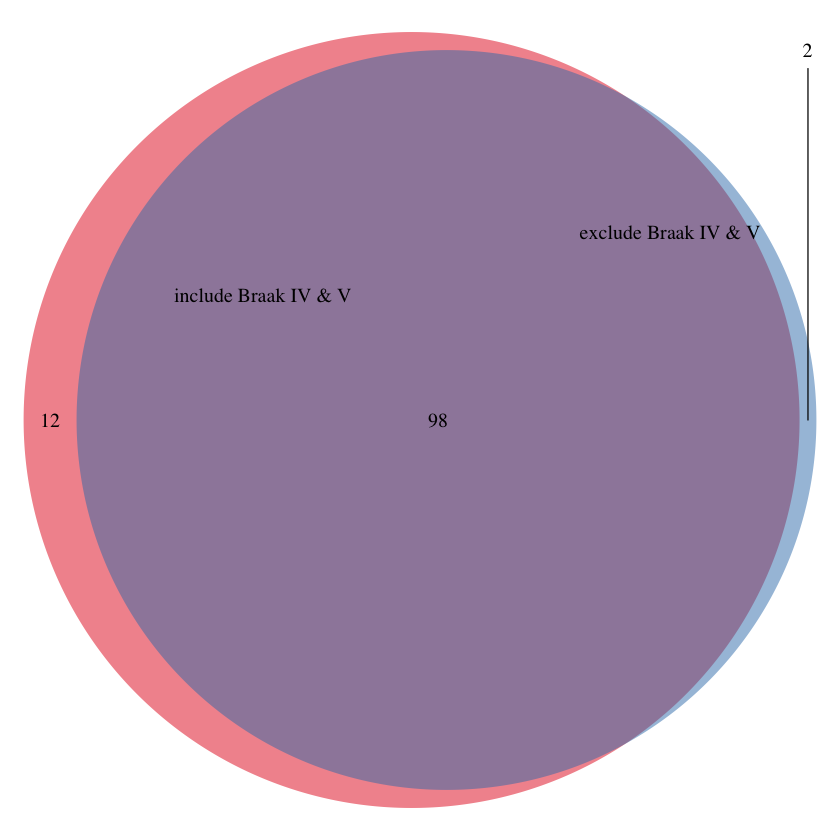

In [90]:
x <- list(set_1 = aging_protective_idx_110, 
          set_2 = aging_protective_idx_100)

p <- venn.diagram(x, filename = NULL, imagetype = "png", fill=c('#E41A1C', '#377EB8'),
                  category.names=c("include Braak IV & V","exclude Braak IV & V"), lwd = 0, alpha = 0.5, cat.dist=c(-0.1, -0.04),
                  height=600,width=600,res=150)
grid.draw(p)

In [103]:
special_idx_2 <- setdiff(aging_protective_idx_100, aging_protective_idx_110)
special_idx_2

In [105]:
special_idx_12 <- setdiff(aging_protective_idx_110, aging_protective_idx_100)
special_idx_12

[1]  332  631  712 1063 1537 1576 1737 1849 1959 2375 2830 3315

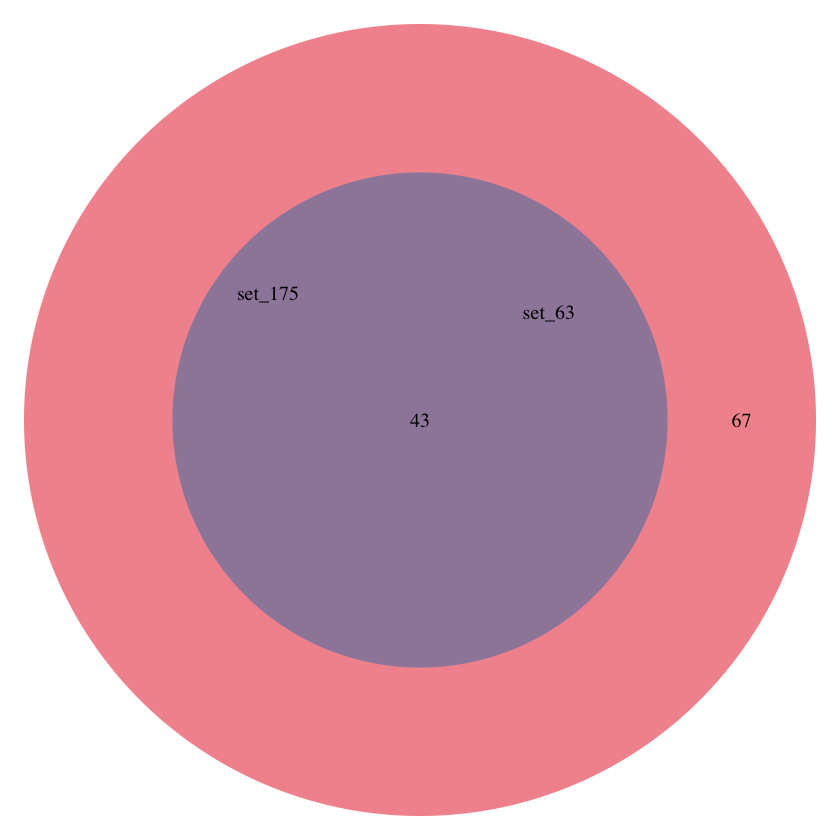

In [53]:
x <- list(set_175 = aging_protective_test_175[aging_protective_test_175$adj.p_value_BH < 0.05, ]$protein, 
          set_63 = aging_protective_test_63[aging_protective_test_63$adj.p_value_BH < 0.05, ]$protein)

p <- venn.diagram(x, filename = NULL, imagetype = "png", fill=c('#E41A1C', '#377EB8'),
                  category.names=c("set_175","set_63"), lwd = 0, alpha = 0.5, cat.dist=c(-0.1, -0.04),
                  height=600,width=600,res=150)
grid.draw(p)

In [55]:
extra_proteins <- setdiff(lm_index[which(aging_protective_test_175$adj.p_value_BH < 0.05)], 
                          pure_sig_age_index[which(aging_protective_test_63$adj.p_value_BH < 0.05)])

In [57]:
length(extra_proteins)

[1] 67

In [252]:
aging_protective_test$p_value_rlm <- aging_protective_test_rlm$p_value
aging_protective_test$adj.p_value_rlm <- aging_protective_test_rlm$adj.p_value

In [253]:
aging_protective_test$lm_BH <- aging_protective_test$adj.p_value_BH < 0.05
aging_protective_test$lm_B <- aging_protective_test$adj.p_value_B < 0.05
aging_protective_test$rlm_BH <- aging_protective_test$adj.p_value_rlm < 0.05

In [254]:
sig_aging_protective <- subset(aging_protective_test, rlm_BH|lm_BH)

In [256]:
sig_aging_protective <- sig_aging_protective[order(sig_aging_protective$adj.p_value_BH), ]

In [257]:
sig_aging_protective

protein                F.p         R_square   p_value      adj.p_value_BH
36 DIAPH1                 0.000459978 0.20029901 3.318354e-10 1.247285e-08  
55 CAND1;CAND2            0.003482549 0.13892448 3.959635e-10 1.247285e-08  
11 NCDN                   0.005785452 0.12310368 1.030780e-08 2.164638e-07  
38 PNCK                   0.025956484 0.07574336 8.604814e-08 1.355258e-06  
42 CDK1                   0.047374135 0.05676092 1.461651e-07 1.841680e-06  
10 CACNA1E                0.092316536 0.03602086 6.951864e-07 7.299457e-06  
30 TRAPPC10               0.051022323 0.05443285 1.390498e-06 1.251448e-05  
28 C2;CFB                 0.008408140 0.11136858 2.847921e-06 1.952179e-05  
53 NAP1L1                 0.020051485 0.08391358 2.645629e-06 1.952179e-05  
63 CHMP1A                 0.008631682 0.11054274 3.098697e-06 1.952179e-05  
34 PIP4K2A;PIP4K2B        0.021341743 0.08193934 3.595046e-06 2.033994e-05  
48 TOMM34                 0.010305968 0.10495645 3.874275e-06 2.033994e-05  
26 PLEKHB1                0.001273335 0.16980704 1.249296e-05 6.054281e-05  
45 OGFRL1                 0.036134535 0.06528803 2.688055e-05 1.209625e-04  
1  CARNS1                 0.005500199 0.12468583 3.211027e-05 1.264342e-04  
60 NCKAP1;NCKAP1L         0.041570554 0.06087068 3.042842e-05 1.264342e-04  
31 MRPS22                 0.014238023 0.09474844 4.317745e-05 1.600105e-04  
20 STX5                   0.155544665 0.02031044 4.654887e-05 1.629211e-04  
44 LGALS3BP               0.007307934 0.11577780 1.145941e-04 3.799701e-04  
52 FAM169A                0.085439852 0.03839894 2.955081e-04 9.308506e-04  
18 RAB11A;RAB11B          0.047793105 0.05648440 6.217556e-04 1.865267e-03  
50 ENPP6                  0.005146427 0.12676416 7.173913e-04 2.054348e-03  
9  PDPK1;PDPK2P           0.009912628 0.10618356 1.478251e-03 4.049122e-03  
8  CNP                    0.002041729 0.15540049 1.587561e-03 4.167347e-03  
24 CD9                    0.001427396 0.16633694 2.316553e-03 5.613186e-03  
62 DNAJB1;DNAJB4          0.130023643 0.02563425 2.240687e-03 5.613186e-03  
12 SNX9                   0.036206052 0.06522565 2.581495e-03 6.023488e-03  
14 NEFL                   0.022682004 0.08001123 3.431092e-03 7.719957e-03  
7  PTGES2                 0.001552532 0.16377759 3.771534e-03 8.193333e-03  
35 PDIA6                  0.020135840 0.08378067 5.692698e-03 1.195467e-02  
51 UBAP2L                 0.029919242 0.07124958 5.918499e-03 1.202792e-02  
13 MOG                    0.003984300 0.13474326 6.222084e-03 1.224973e-02  
56 ANLN                   0.018690701 0.08613833 6.849819e-03 1.307693e-02  
6  NEFM                   0.017641115 0.08796772 1.026356e-02 1.847441e-02  
40 PSD3                   0.030008684 0.07115522 1.006790e-02 1.847441e-02  
22 SIRT2                  0.004423432 0.13148808 1.293507e-02 2.263637e-02  
29 RPS16                  0.042154963 0.06043118 1.539586e-02 2.621457e-02  
23 SLC44A1                0.005424493 0.12511930 1.844793e-02 3.058472e-02  
33 MAG                    0.011772923 0.10075643 1.986724e-02 3.129091e-02  
46 INA;NEFH;NEFL;NEFM;VIM 0.032861793 0.06828520 1.966774e-02 3.129091e-02  
37 PDE1A;PDE1C            0.034346431 0.06688981 2.674160e-02 4.109075e-02  
16 PNMA8B                 0.009203300 0.10852347 2.790829e-02 4.155970e-02  
57 RPL31                  0.037500465 0.06411762 2.836615e-02 4.155970e-02  
58 INA;NEFH;NEFL;NEFM     0.048617907 0.05594721 3.973229e-02 5.688941e-02  
43 PIP4K2A                0.037094999 0.06446048 6.141081e-02 8.231662e-02  
4  KBTBD11                0.020544895 0.08314399 8.787215e-02 1.129785e-01  
   adj.p_value_B p_value_rlm  adj.p_value_rlm lm_BH lm_B  rlm_BH
36 2.090563e-08  6.874867e-12 2.165583e-10     TRUE  TRUE  TRUE 
55 2.494570e-08  1.593298e-09 3.345926e-08     TRUE  TRUE  TRUE 
11 6.493915e-07  1.650181e-08 2.599035e-07     TRUE  TRUE  TRUE 
38 5.421033e-06  7.208092e-08 7.568497e-07     TRUE  TRUE  TRUE 
42 9.208402e-06  6.609213e-08 7.568497e-07     TRUE  TRUE  

In [116]:
aging_protective_index_v1 <- which((aging_protective_test$adj.p_value < 0.01) & (aging_protective_test$adj.F.p < 0.05))
length(aging_protective_index_v1)

In [75]:
plot_top_43_index <- pure_sig_age_index[order(aging_protective_test$adj.p_value_BH)[1:43]]

In [77]:
write.table(plot_top_43_index, "age_protective_proteins_43.tsv", sep = "\t", 
            row.names = FALSE, col.names = FALSE,quote = FALSE)

In [130]:
sig_protective_proteins<- aging_protective_test[which((aging_protective_test$adj.p_value < 0.05)), ]

In [166]:
for ( i in rownames(protein_intensity_combat)[plot_top_43_index])
    cat(i, end = "\n")

DIAPH1 
CAND1;CAND2 
NCDN 
PNCK 
CDK1 
CACNA1E 
TRAPPC10 
C2;CFB 
NAP1L1 
CHMP1A 
PIP4K2A;PIP4K2B 
TOMM34 
PLEKHB1 
OGFRL1 
CARNS1 
NCKAP1;NCKAP1L 
MRPS22 
STX5 
LGALS3BP 
FAM169A 
RAB11A;RAB11B 
ENPP6 
PDPK1;PDPK2P 
CNP 
CD9 
DNAJB1;DNAJB4 
SNX9 
NEFL 
PTGES2 
PDIA6 
UBAP2L 
MOG 
ANLN 
NEFM 
PSD3 
SIRT2 
RPS16 
SLC44A1 
MAG 
INA;NEFH;NEFL;NEFM;VIM 
PDE1A;PDE1C 
PNMA8B 
RPL31 


In [143]:
aging_protective_index_v1 <- pure_sig_age_index[aging_protective_index_v1]

In [144]:
protein_intensity_combat[aging_protective_index_v1, ]

intensity_20190325_121_S16_020_CHC_011
PTGES2   8.856092                             
CNP     13.966375                             
CD9      9.096391                             
PLEKHB1  7.280271                             
DIAPH1   6.862899                             
        intensity_20190325_125_S16_044_CHC_007
PTGES2   9.204755                             
CNP     14.468092                             
CD9     10.002821                             
PLEKHB1  7.958073                             
DIAPH1   7.197941                             
        intensity_20190325_127_S16_094_CHC_004
PTGES2   9.227288                             
CNP     14.582166                             
CD9      9.740737                             
PLEKHB1  7.562761                             
DIAPH1   7.115541                             
        intensity_20190325_16_04_037_AD_008
PTGES2   9.003747                          
CNP     13.426442                          
CD9      8.542277                          
PLEKHB1  6.389236                          
DIAPH1   7.293466                          
        intensity_20190325_183_S10_292_AD_010
PTGES2   8.753085                            
CNP     15.709342                            
CD9     10.906862                            
PLEKHB1  8.917668                            
DIAPH1   7.472353                            
        intensity_20190325_194_S02_055_ND_005
PTGES2   8.948958                            
CNP     15.333795                            
CD9     10.199050                            
PLEKHB1  8.028913                            
DIAPH1   7.001905                            
        intensity_20190325_31_01_184_AD_006
PTGES2   8.990496                          
CNP     14.948910                          
CD9     10.340155                          
PLEKHB1  8.480909                          
DIAPH1   6.742699                          
        intensity_20190325_57_S97_235_AD_003
PTGES2   8.747040                           
CNP     14.663361                           
CD9      9.878431                           
PLEKHB1  8.550192                           
DIAPH1   7.309239                           
        intensity_20190325_77_S11_072_ND_012
PTGES2   9.055711                           
CNP     14.133069                           
CD9      9.351361                           
PLEKHB1  6.952555                           
DIAPH1   7.246439                           
        intensity_20190325_79_S07_308_ND_009 ⋯
PTGES2   9.023287                            ⋯
CNP     15.115988                            ⋯
CD9     10.437824                            ⋯
PLEKHB1  8.107891                            ⋯
DIAPH1   7.140282                            ⋯
        intensity_20190507_21_01_032_AD_221 intensity_20190507_27_00_204_AD_211
PTGES2   9.387029                            9.123702                          
CNP     14.572498                           15.386371                          
CD9      9.885220                           10.506441                          
PLEKHB1  7.359140                            8.771126                          
DIAPH1   6.737499                            6.587000                          
        intensity_20190507_29_S99_240_AD_219
PTGES2   9.164089                           
CNP     13.857879                           
CD9      9.158488                           
PLEKHB1  7.701932                           
DIAPH1   7.408205                           
        intensity_20190507_30_S05_040_AD_209
PTGES2   9.317275                           
CNP     13.831455                           
CD9      8.886778                           
PLEKHB1  7.191345                           
DIAPH1   7.433683                           
        intensity_20190507_63_04_027_AD_217
PTGES2   8.927282                          
CNP     14.928273                          
CD9     10.081073                          
PLEKHB1  8.322385                          
DIAPH1   7.200532   

In [60]:
plot_protective_proteins_aging <- function(index){
    temp_prot <- data.frame(age = as.numeric(metadata$age),
                            group = as.character(metadata$GROUP),
                            intensity = as.numeric(protein_intensity_combat[index,]))
    
    #print(length(which((temp_prot$age >= 80)&(temp_prot$intensity < 6.5)&(temp_prot$group == "ND"))))
    
    temp_prot <- subset(temp_prot, group != "AD")
    temp_prot$group <- factor(temp_prot$group, levels=c("ND", "AD", "CHC"))
    
    CHC_mean <- mean(temp_prot[which(temp_prot$group == "CHC"), ]$intensity)
    
    x1 <- min(temp_prot[which(temp_prot$group == "CHC"), ]$age)
    y1 <- CHC_mean
    x2 <- max(temp_prot[which(temp_prot$group == "CHC"), ]$age)
    y2 <- CHC_mean
    
    y_start <- round(min(temp_prot$intensity)) - 0.5
    y_end <- round(max(temp_prot$intensity)) + 0.5
    
    #y_start <- 6
    #y_end <- 16
    
    #if(y_start == y_end)
    #    y_end = y_end + 1
    
    p <- ggplot(subset(temp_prot, group == "ND"), aes(x = age, y = intensity, col = group))+
        geom_point() +
        geom_smooth(method = "lm", formula = y ~ x, fullrange=TRUE, level = 0.9) +
        geom_point(data = subset(temp_prot, group != "ND"), mapping = aes(x = age, y = intensity, col = group)) +
        xlab("Age [y]") +
        ylab("log2(protein intensity)") +
        ggtitle(rownames(protein_intensity_combat)[index]) +
    
        geom_segment(aes(x = x1, y = y1, xend = x2, yend = y2), 
                     color = color_CHC, size = 1,
                     data = temp_prot) + 
    
        scale_y_continuous(limits = c(y_start, y_end), breaks=seq(y_start, y_end, 1)) +
    
        scale_color_manual(name="Group", breaks = c("ND", "AD", "CHC"), 
                           values = c(color_ND, color_AD, color_CHC),
                           guide = guide_legend(override.aes = list(alpha = 1, linetype = c("solid", "solid")))
                          )+
    
        
    
        theme(#plot.background = element_rect(),    # Background of the entire plot
          panel.background = element_rect(fill = "white"),   # Background of plotting area
          #panel.border = element_rect(),       # Border around plotting area.
                                               # fill argument should be NA
  
          #panel.grid = element_line(),         # All grid lines
          #panel.grid.major = element_line(),   # Major grid lines
          #panel.grid.minor = element_line(),   # Minor grid lines
  
          panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Vertical major grid lines
          panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Horizontal major grid lines
          panel.grid.minor.x = element_line(), # Vertical minor grid lines
          panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.title = element_text(hjust = 0.5),
          axis.title.x = element_text(color = "black", size = 12),
          axis.title.y = element_text(color = "black", size = 12),
          
          axis.text.x = element_text(size = 12, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = 12, color = "black"),
          
          axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
         )
    return(p)
    
}

In [61]:
aging_protective_plots <- NULL

In [62]:
for(i in 1:length(extra_proteins)){
    p  <- plot_protective_proteins_aging(extra_proteins[i])
    aging_protective_plots[[i]] <- p
}

In [64]:
p <- plot_grid(plotlist = aging_protective_plots[1:33], ncol = 3)
save_plot("100_plus_plots/proteomics/age_protective_protein_extra_33.pdf", p, base_height = 40, base_width = 15)

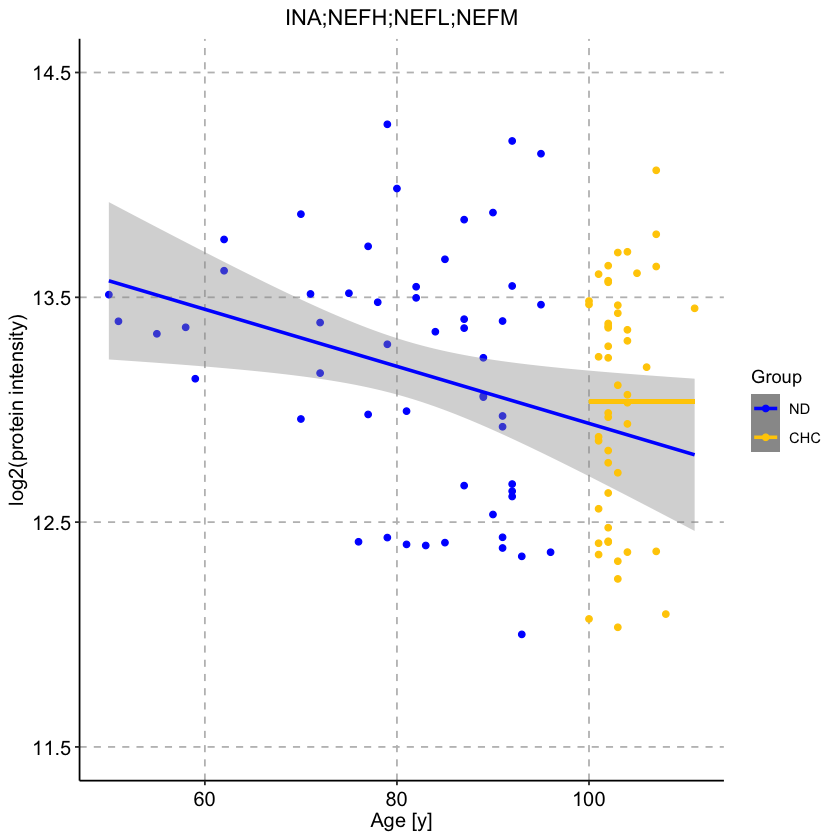

In [265]:
plot_protective_proteins_aging(which(rownames(protein_intensity_combat) == "INA;NEFH;NEFL;NEFM"))

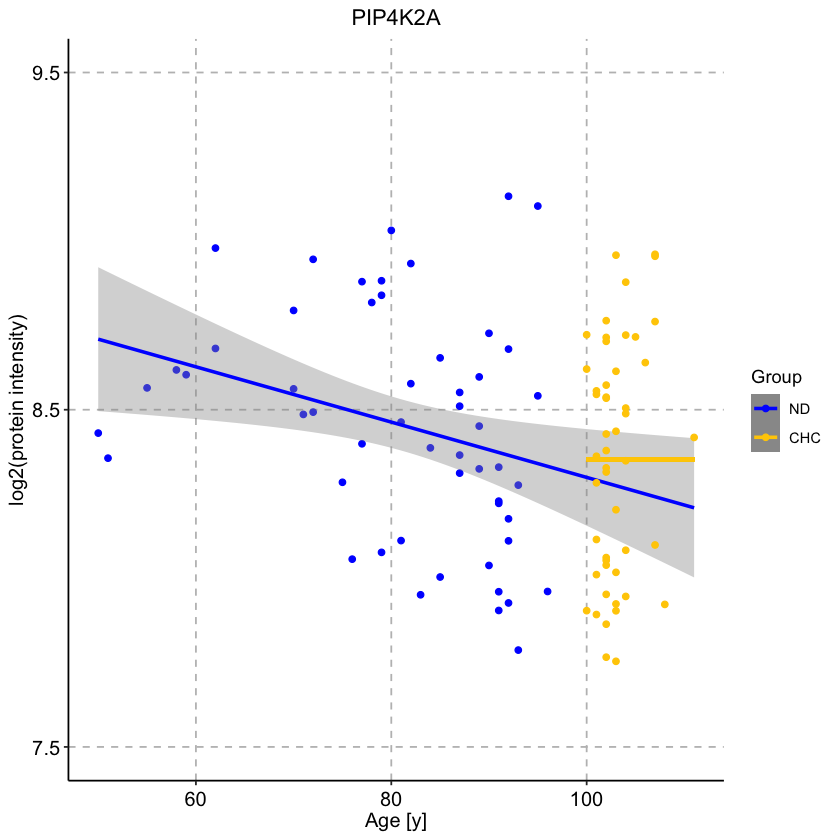

In [266]:
plot_protective_proteins_aging(which(rownames(protein_intensity_combat) == "PIP4K2A"))

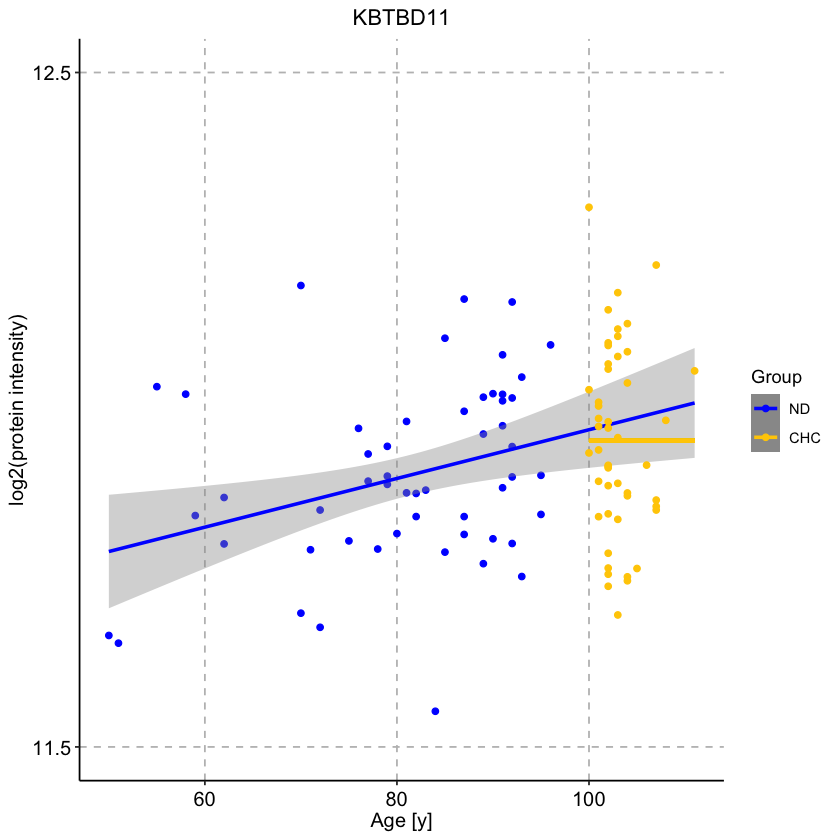

In [267]:
plot_protective_proteins_aging(which(rownames(protein_intensity_combat) == "KBTBD11"))

In [95]:
MMSE_data <- read_excel("100_plus_project/20190513_dataExtraction.xlsx",sheet=1,col_names=TRUE, na="NA")
#MMSE_data
MMSE_data <- MMSE_data[c('NBB', 'MMSE_LV')]
nrow(MMSE_data)

metadata$MMSE <- rep(NA, nrow(metadata))

for (i in 1:nrow(metadata)){
    if (metadata[i,]$GROUP == "CHC"){
        metadata[i,]$MMSE <- MMSE_data[which(MMSE_data$NBB == metadata[i,]$nbb),]$MMSE_LV
    }
}

[1] 65

In [96]:
metadata$MMSE <- as.numeric(metadata$MMSE)

In [97]:
metadata$group <- metadata$GROUP

In [98]:
metadata[which(metadata$MMSE >= 26), ]$group <- "CHC_H"
metadata[which((metadata$MMSE < 26) & (metadata$MMSE > 22)),]$group <- "CHC_M"
metadata[which(metadata$MMSE <= 22), ]$group <- "CHC_L"

In [119]:
test_abundance_for_aging_protective_proteins <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- cbind(metadata, intens)
    
    fitLM <- lm(intens~age, subset(protein_metadata, GROUP == "ND"))
    
    #print(summary(fitLM)$coefficients[2,][c(1,4)])
    
    predict_intens_LM <- predict(fitLM, subset(protein_metadata, group == "CHC_H"))
    
    
    
    if(fitLM$coefficients[2] > 0){
        return(c(summary(fitLM)$coefficients[2,][4], 
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, group == "CHC_H")$intens,
                      alternative = "greater")$p.value))
    }
    if(fitLM$coefficients[2] < 0){
        return(c(summary(fitLM)$coefficients[2,][4],
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, group == "CHC_H")$intens,
                      alternative = "less")$p.value))
    }
}

In [120]:
aging_protective_test <- as.data.frame(t(sapply(pure_sig_age_index, test_abundance_for_aging_protective_proteins)))

In [121]:
aging_protective_test <- cbind(rownames(protein_intensity_combat)[pure_sig_age_index],
                               aging_protective_test)

In [122]:
colnames(aging_protective_test) <- c("protein", "F.p", "p_value")

In [123]:
aging_protective_test$adj.p_value <- p.adjust(aging_protective_test$p_value, method = "BH")

aging_protective_index <- which((aging_protective_test$adj.p_value < 0.01) & 
                                (aging_protective_test$F.p < 0.01))

In [124]:
aging_protective_index <- aging_protective_index[order(aging_protective_test[aging_protective_index, ]$adj.p_value)]

In [125]:
aging_protective_test[aging_protective_index,]

protein     F.p         p_value      adj.p_value 
36 DIAPH1      0.000459978 1.633217e-07 1.028927e-05
55 CAND1;CAND2 0.003482549 1.025323e-05 3.229768e-04
11 NCDN        0.005785452 3.216868e-05 6.755424e-04
44 LGALS3BP    0.007307934 1.507390e-04 2.040245e-03
1  CARNS1      0.005500199 6.049345e-04 5.240820e-03
26 PLEKHB1     0.001273335 1.177122e-03 6.741699e-03
28 C2;CFB      0.008408140 1.875843e-03 8.441295e-03
50 ENPP6       0.005146427 1.868978e-03 8.441295e-03
63 CHMP1A      0.008631682 2.093545e-03 8.792888e-03

In [126]:
length(aging_protective_index)

[1] 9

In [127]:
aging_protective_index <- pure_sig_age_index[aging_protective_index]

In [128]:
aging_protective_index_v1

[1]    4  411  437  491  721 1394 1468 1488 1867 2219 2583 3162 3549

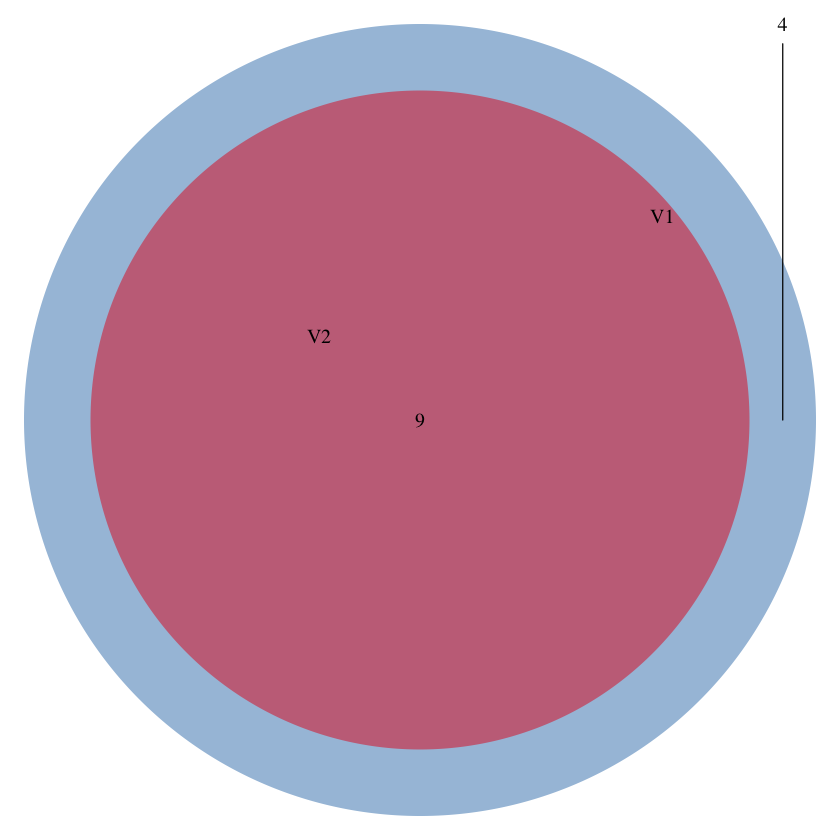

In [129]:
x <- list(V2 = aging_protective_index, 
          V1 = aging_protective_index_v1)

path <- "Temp_results/overlap_pathology_and_aging_protein_lm.png"
p <- venn.diagram(x, filename = NULL, imagetype = "png", fill=c('#E41A1C', '#377EB8'),
             category.names=c("V2","V1"), lwd = 0, alpha = 0.5, cat.dist=c(-0.1, -0.04),
             height=600,width=600,res=150)
grid.draw(p)

In [112]:
plot_protective_proteins_aging <- function(index){
    temp_prot <- data.frame(age = as.numeric(metadata$age),
                            Sex = as.character(metadata$sex),
                            group = as.character(metadata$group),
                            label = as.character(metadata$GROUP),
                            Braak = as.factor(metadata$fBraak),
                            intensity = as.numeric(protein_intensity_combat[index,]))
    
    
    
    temp_prot$group <- factor(temp_prot$group, levels=c("ND", "AD", "CHC", "CHC_H", "CHC_M", "CHC_L"))
    
    temp_prot <- subset(temp_prot, group != "AD")
    
    #temp_prot$alpha <- 1
    #temp_prot[which(temp_prot$group %in% c("CHC", "CHC_M", "CHC_L")), ]$alpha <- 1
    
    CHC_mean <- mean(temp_prot[which(temp_prot$label == "CHC"), ]$intensity)
    
    x1 <- min(temp_prot[which(temp_prot$label == "CHC"), ]$age)
    y1 <- CHC_mean
    x2 <- max(temp_prot[which(temp_prot$label == "CHC"), ]$age)
    y2 <- CHC_mean
    
    y_start <- round(min(temp_prot$intensity)) - 0.5
    y_end <- round(max(temp_prot$intensity)) + 0.5
    
    p <- ggplot(subset(temp_prot, group == "ND"), aes(x = age, y = intensity))+
        #geom_point() +
        geom_smooth(method = "lm", formula = y ~ x, fullrange=TRUE, level = 0.9) +
        geom_point(data = subset(temp_prot, group != ""), 
                   mapping = aes(x = age, y = intensity, col = Braak)) +
        xlab("Age [y]") +
        ylab("log2(protein intensity)") +
        ggtitle(rownames(protein_intensity_combat)[index]) +
    
        scale_y_continuous(limits = c(y_start, y_end), breaks=seq(y_start, y_end, 1)) +
    
        #scale_color_manual(name="Group", breaks = c("ND", "AD", "CHC", "CHC_H", "CHC_M", "CHC_L"), 
        #               values = c(color_ND, color_AD, color_CHC, '#E41A1C', '#4DAF4A', '#377EB8'),
        #               guide = guide_legend(override.aes = list(alpha = 1, 
        #                                                        linetype = c("blank", 
        #                                                                     "blank", "blank", "blank")))
        #              )+
    
    
        scale_color_manual(name="Braak", breaks = 1:6, 
                       values = c('#377EB8', '#4DAF4A', '#984EA3', "#FFCC00", '#FF7F00', '#E41A1C'),
                       guide = guide_legend(override.aes = list(alpha = 1, 
                                                                linetype = c("blank", "blank",  "blank",
                                                                             "blank",  "blank")))
                      )+
    
        theme(panel.background = element_rect(fill = "white"),   # Background of plotting area
              #panel.border = element_rect(),       # Border around plotting area.
                                                   # fill argument should be NA
      
              #panel.grid = element_line(),         # All grid lines
              #panel.grid.major = element_line(),   # Major grid lines
              #panel.grid.minor = element_line(),   # Minor grid lines
      
              panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                                    color = "gray"), # Vertical major grid lines
              panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                                    color = "gray"), # Horizontal major grid lines
              panel.grid.minor.x = element_line(), # Vertical minor grid lines
              panel.grid.minor.y = element_line(),  # Vertical major grid lines
            
              plot.title = element_text(hjust = 0.5),
              axis.title.x = element_text(color = "black", size = 12),
              axis.title.y = element_text(color = "black", size = 12),
              
              axis.text.x = element_text(size = 12, color = "black", 
                                         vjust = 0.5, hjust = 0.5),
              axis.text.y = element_text(size = 12, color = "black"),
              
              axis.line = element_line(size = 0.5, linetype = "solid",
                                   colour = "black")
             )
    return(p)
    
}

In [113]:
aging_protective_plots <- NULL

for(i in 1:2){
p  <- plot_protective_proteins_aging(special_63_idx_2[i])
aging_protective_plots[[i]] <- p
}


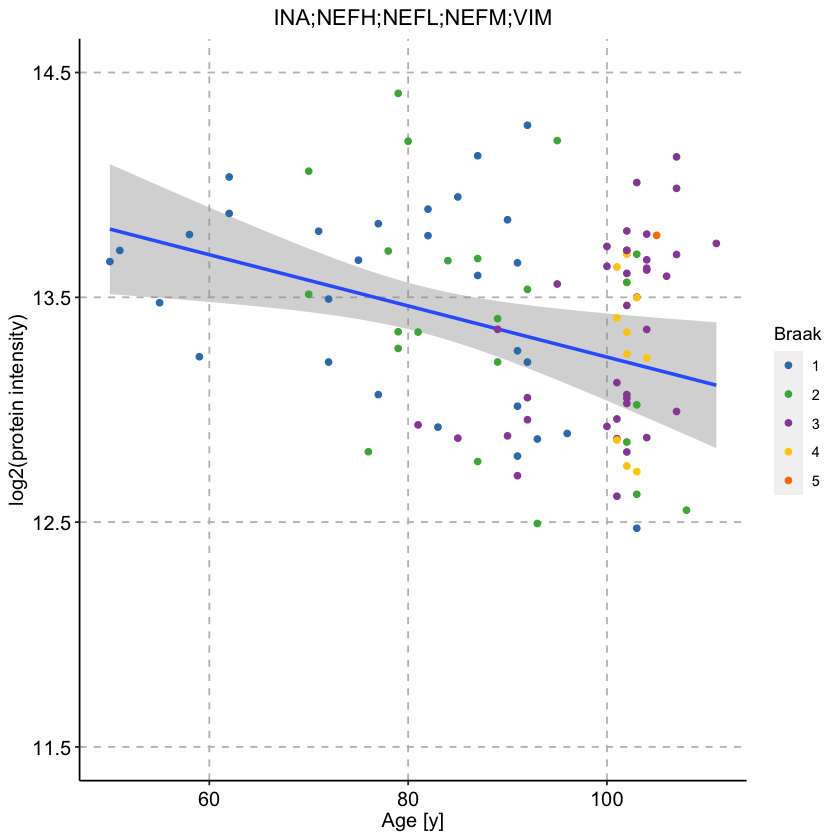

In [114]:
p

In [115]:
p <- plot_grid(plotlist = aging_protective_plots, ncol = 2)
save_plot("100_plus_plots/proteomics/Aging_protective_protein_Braak4&5_43_41_2.pdf", p, limitsize = FALSE, base_height = 5, base_width = 10)

In [255]:
4829 - 3448

[1] 1381